## This is for imports and and loading in the CSV from Google Sheets

This is some other shit like comments etc



In [218]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *
import gspread

from google.colab import auth
auth.authenticate_user()

# modelling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer #Z-score variables
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer #Z-score variables, Polynomial
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model eva

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# performance
from sklearn.metrics import accuracy_score, confusion_matrix,\
 f1_score, recall_score, precision_score, roc_auc_score, silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import calibration_curve

# model validation imports
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # Decision Tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # random forest
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor # gradient boosting

from plotnine import ggplot, aes, geom_boxplot, facet_wrap
from plotnine.data import mpg

%matplotlib inline

In [219]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1I2oPAUzOwsDey5D8Wf5pN7cHKR_wCPWO-gJrCR4Zf-g/edit?usp=sharing'
workbook = gc.open_by_url(spreadsheet_url)

sheet = workbook.sheet1  # or workbook.worksheet('your-sheet-name')
data = sheet.get_all_values()
df = pd.DataFrame(data)
df.columns = df.iloc[0]  # Set first row as column names
df = df.iloc[1:]         # Remove first row

In [220]:
#df = pd.read_csv("/content/Data Science Final Dataset - Sheet1.csv")
df.head(6)
# List columns as a list
# columns_list = df.columns.tolist()
# print(columns_list)
df.count()

# Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

# Drop rows with any NaN values
df.dropna(inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Check again for missing values
print(df.isnull().sum())

# Convert continuous values to a numeric data type, coerce errors to NaN
df['YearsSinceOpen'] = pd.to_numeric(df['YearsSinceOpen'], errors='coerce')
df['DistancefromChapman'] = pd.to_numeric(df['DistancefromChapman'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Competitiveness'] = pd.to_numeric(df['Competitiveness'], errors='coerce')
df['CompetitorDensity'] = pd.to_numeric(df['CompetitorDensity'], errors='coerce')

# Now, drop any rows where 'YearsSinceOpen' is NaN
df = df.dropna(subset=['YearsSinceOpen'])

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

df.count()

0
Name                      0
RestaurantType            0
YearOpened                0
Culture                   0
Specialty                 0
AverageMealPrice          0
DistancefromChapman       0
Rating                    0
Reviews                   0
CompetitorDensity         0
HealthInspectionRating    0
AlcoholAvailability       0
YearsSinceOpen            0
Competitiveness           0
dtype: int64


0
Name                      147
RestaurantType            147
YearOpened                147
Culture                   147
Specialty                 147
AverageMealPrice          147
DistancefromChapman       147
Rating                    147
Reviews                   147
CompetitorDensity         147
HealthInspectionRating    147
AlcoholAvailability       147
YearsSinceOpen            147
Competitiveness           147
dtype: int64

##Q1: (Supervised Model) Impact of Culture, Specialty, Price and Alcohol on Longevity: How do the cultural background of the cuisine, its specialty, and the availability of alcohol influence a restaurant's operational lifespan?

###Variables Involved:

- Restaurant Type (Categorical)
- Culture (Categorical)
- Specialty (Categorical)
- Alcohol Availability (Categorical)
- Price (Categorative)
- Predicting: Years in Operation (Continuous)

###Cleaning:
- Handle missing values appropriately for each variable.
- Use OneHotEncoder() for Categorical Values.

###Modeling/Computation:
- Utilize a Gradient Boosting Tree to analyze the impact of culture, specialty, price, and alcohol availability on restaurant longevity.
- A Train/Test split with 80/20 split will be used
- Train the model with the variables mentioned to predict the years in operation.

###Graphs:
- P1: Boxplot with faceted graphs for different price ranges of \$1-15, \$15-50, \$50-100, and \$100+. The graph plots the years that restaurants have been open for each of the alcohol availability categories
- P2: Boxplot that plots the years since open for different cultures
- P3: Boxplot that plots the years since open for different specialties
- Boxplots for P1, P2, and P3 that exclude the one outlier to show a more granular view of the variance for the years open for alcohol offerings, price ranges, different cultures and specialties respectively

###Brief Discussion:
Using linear regression and data preprocessing, this study examines the influence of culture, specialty, price, and alcohol availability on restaurant longevity. The analysis provides valuable insights into how these factors collectively shape the operational lifespan of restaurants.

In [ ]:

# # drop missing values
# df.dropna(inplace = True)
# df.reset_index(drop = True, inplace = True)


predictors = [
    "RestaurantType",
    "Culture",
    "Specialty",
    "AlcoholAvailability",
    "AverageMealPrice"
]

categ = predictors

X = df[predictors]
y = df['YearsSinceOpen']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categ),
                                     remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("pre", preprocess),
                ("poly", PolynomialFeatures(degree = 1)),
                ("linearregression", lr)])

# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assess
print("THIS IS FOR LINEAR REGRESSION\n")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))


THIS IS FOR LINEAR REGRESSION

Train MSE :  20.174301443129906
Train MAE :  3.624745170754101
Train MAPE:  1.1363503673616275
Train R2  :  0.36516479137739577

Test MSE  :  125.47097320696376
Test MAE  :  7.350153309139199
Test MAPE :  1.3638560626695198
Test R2   :  -0.3130683242589227


In [ ]:
# Create a pipeline with preprocessing and LassoCV
pipe = Pipeline([("pre", preprocess),
                 ("poly", PolynomialFeatures(degree = 1)),
                ("lasso", LassoCV(cv=5))])

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Fit the pipeline (LassoCV will find the best alpha value)
pipe.fit(X_train, y_train)

# Access the best alpha value
best_alpha = pipe.named_steps['lasso'].alpha_

# Predict using the model
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Assess the model's performance
print("This is for Lasso with alpha = ", str(best_alpha), "\n")
print("Train MSE : ", mean_squared_error(y_train, y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train, y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train, y_pred_train))
print("Train R2  : ", r2_score(y_train, y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test, y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test, y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test, y_pred_test))
print("Test R2   : ", r2_score(y_test, y_pred_test))

This is for Lasso with alpha =  0.6070567609029145 

Train MSE :  46.978888158375334
Train MAE :  5.108481262327417
Train MAPE:  1.5114831947627234
Train R2  :  0.0

Test MSE  :  40.35871867923151
Test MAE  :  5.747293447293448
Test MAPE :  1.879816633936795
Test R2   :  -5.0846929003922625e-05


In [ ]:

# Create a pipeline with preprocessing and RidgeCV
pipe = Pipeline([("pre", preprocess),
                 ("poly", PolynomialFeatures(degree = 1)),
                ("ridge", RidgeCV(cv=5))])

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Fit the pipeline (RidgeCV will find the best alpha value)
pipe.fit(X_train, y_train)

# Access the best alpha value
best_alpha = pipe.named_steps['ridge'].alpha_

# Predict using the model
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Assess the model's performance
print("This is for Ridge with alpha = ", str(best_alpha), "\n")
print("Train MSE : ", mean_squared_error(y_train, y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train, y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train, y_pred_train))
print("Train R2  : ", r2_score(y_train, y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test, y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test, y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test, y_pred_test))
print("Test R2   : ", r2_score(y_test, y_pred_test))
print()

This is for Ridge with alpha =  10.0 

Train MSE :  36.82800304536157
Train MAE :  4.660177928591696
Train MAPE:  1.3687497963345208
Train R2  :  0.2695295937614762

Test MSE  :  32.961581259841815
Test MAE  :  4.480803064232617
Test MAPE :  1.7584128512932307
Test R2   :  -0.2745069227469341



In [ ]:
# QUESTION 1

# drop missing values
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.isnull().sum()

predictors = [
    "RestaurantType",
    "Culture",
    "Specialty",
    "AlcoholAvailability",
    "AverageMealPrice"
]

categ = predictors

X = df[predictors]
y = df['YearsSinceOpen']

# z score
preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categ),
                                     remainder = "passthrough")

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1234)


MAX_DEPTH = 3
MIN_SAMPLES_LEAF = 5

#tree = RandomForestRegressor(max_depth=MAX_DEPTH, min_samples_leaf=MIN_SAMPLES_LEAF, random_state=1234)
tree = GradientBoostingRegressor(random_state = 1234)

pipe = Pipeline([("pre", preprocess),
                ("tree", tree)])


# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assess
print("This is for Gradient Boosting Tree\n")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))


This is for Gradient Boosting Tree

Train MSE :  26.227291108597804
Train MAE :  3.4085387698780987
Train MAPE:  0.9727000527595079
Train R2  :  0.4534250804038654

Test MSE  :  23.282722329310435
Test MAE  :  3.8395562092288347
Test MAPE :  1.1273261411392759
Test R2   :  0.3584848733658036


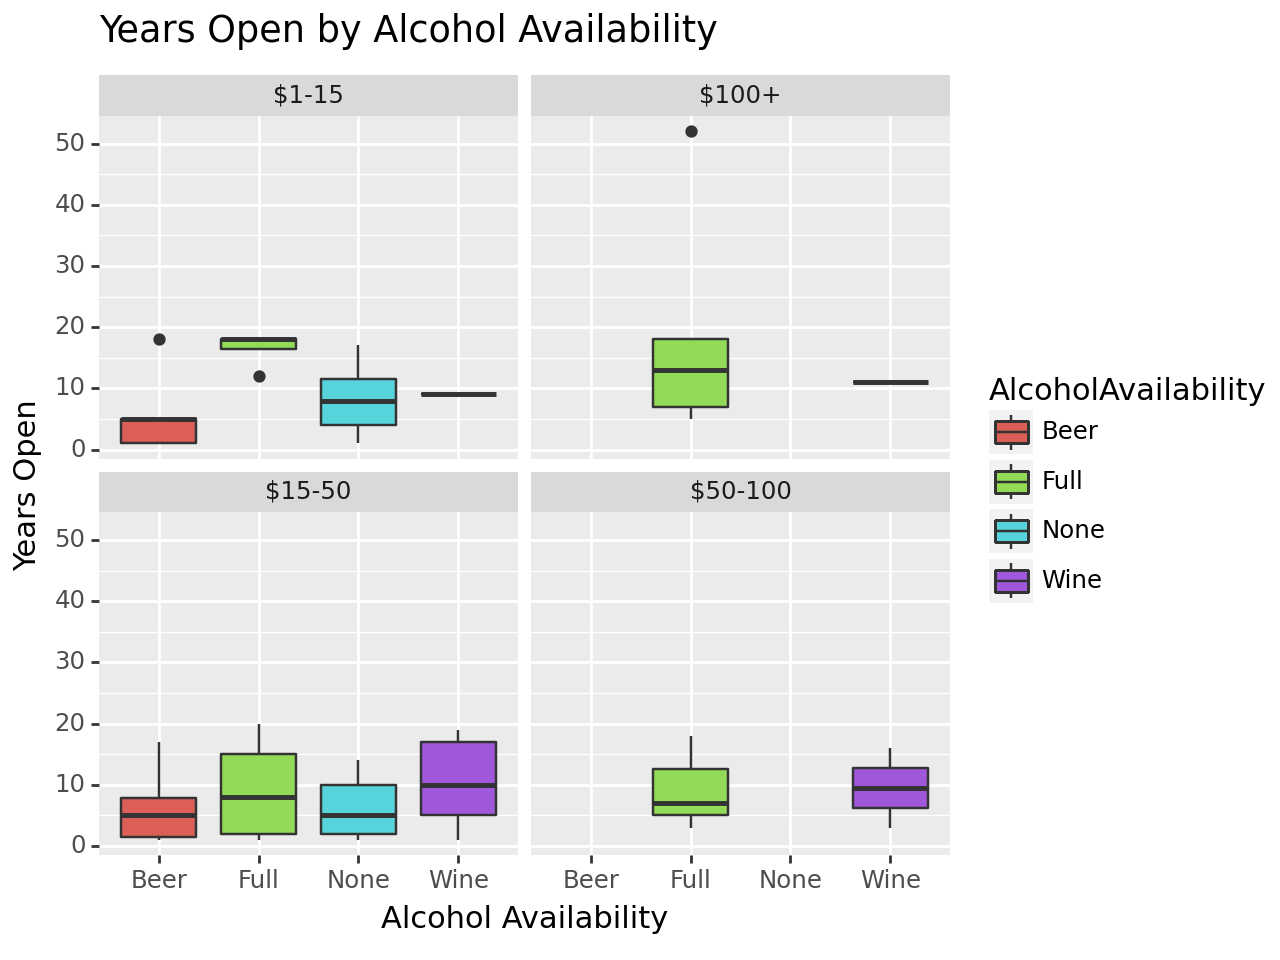

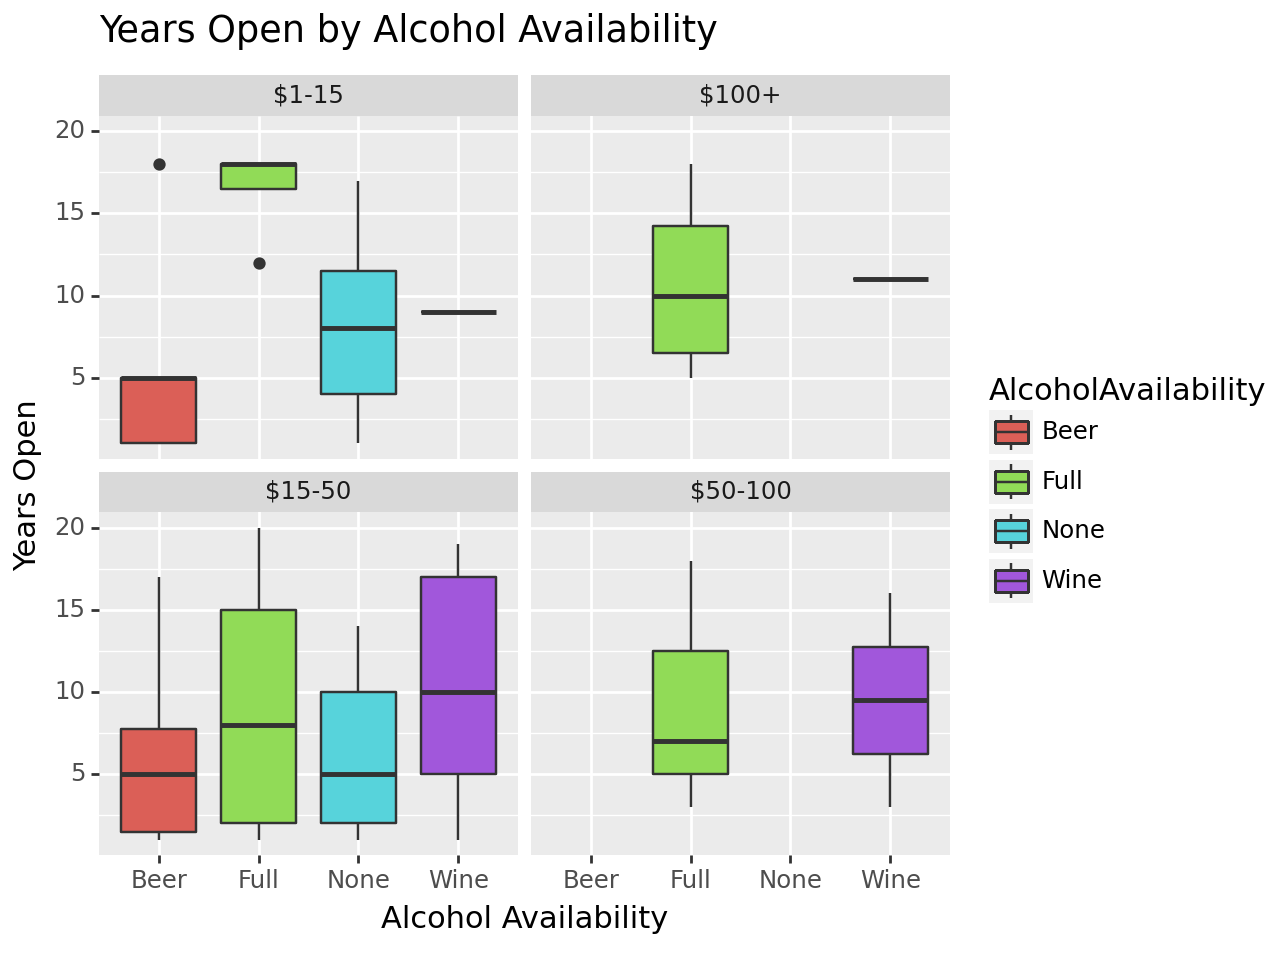

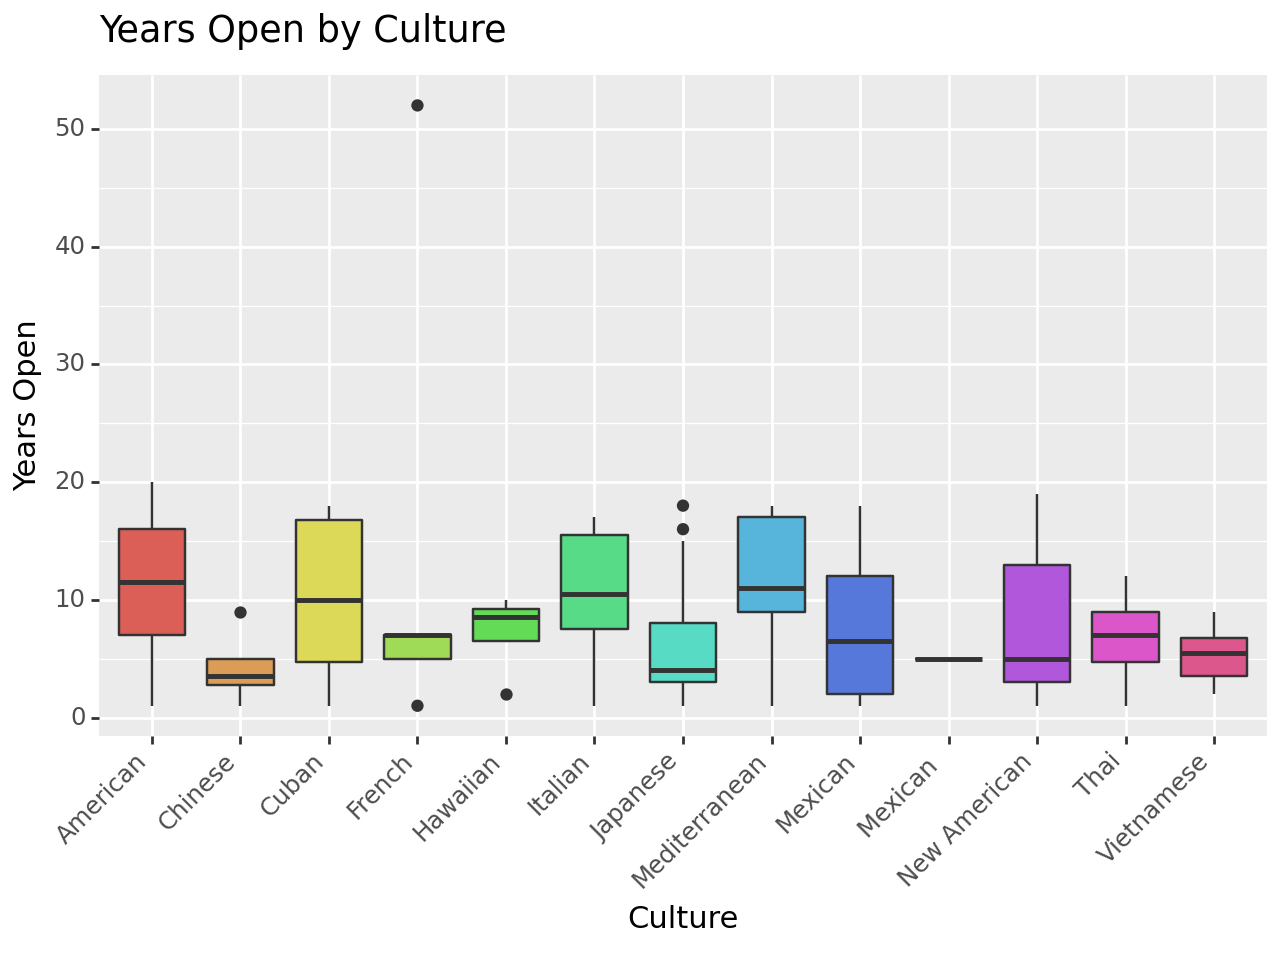

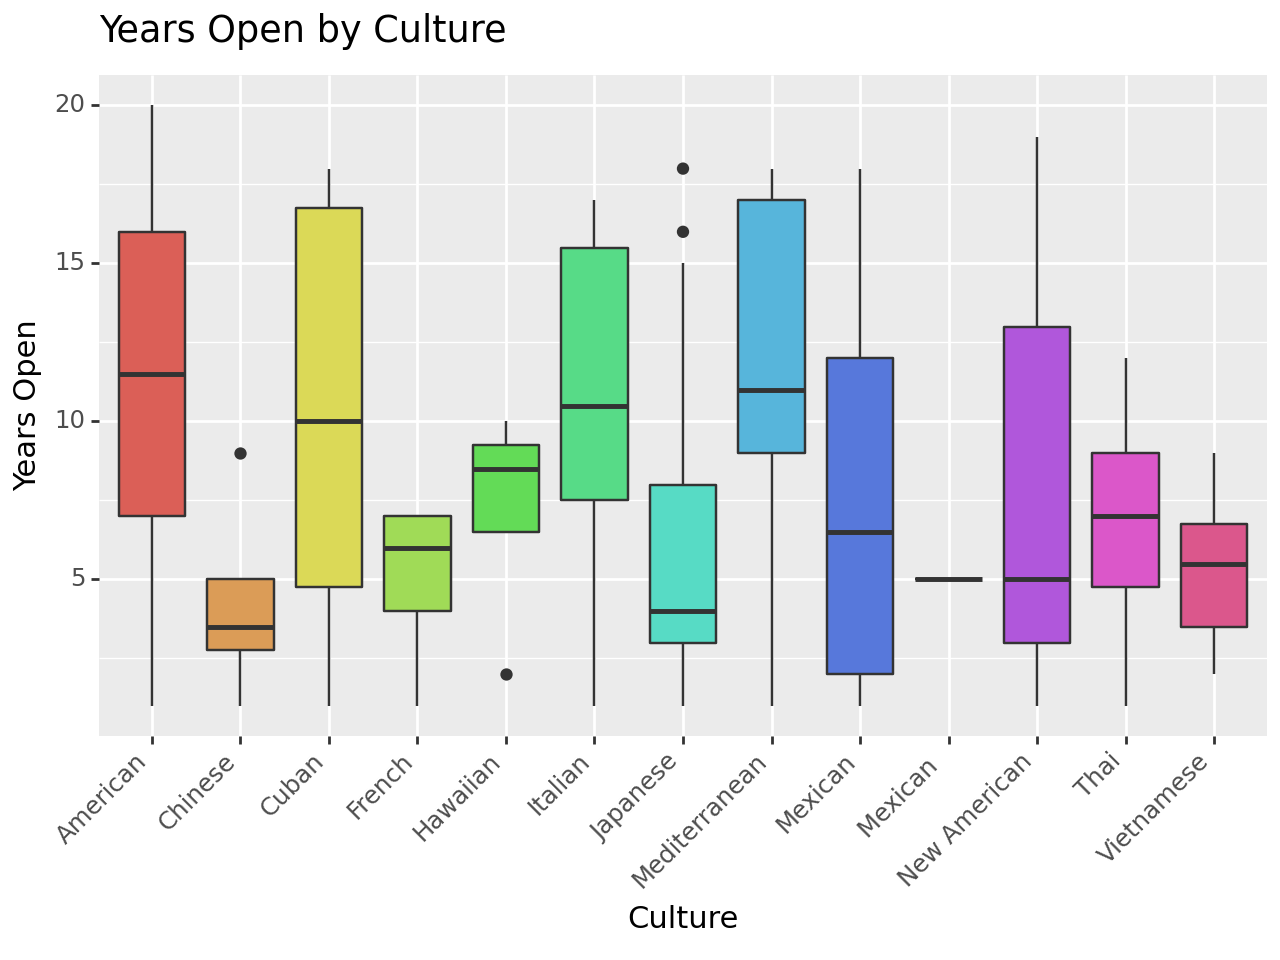

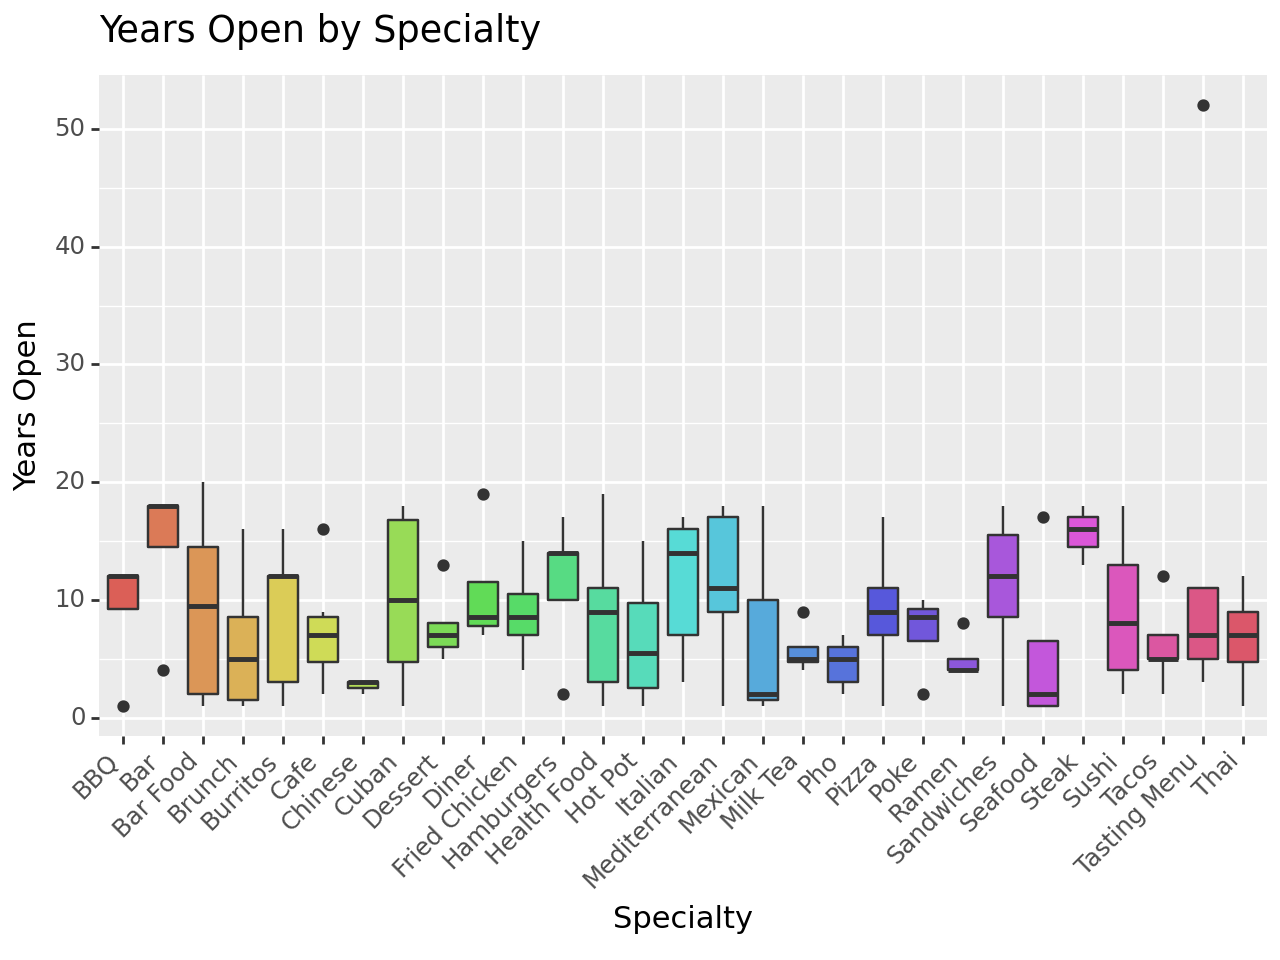

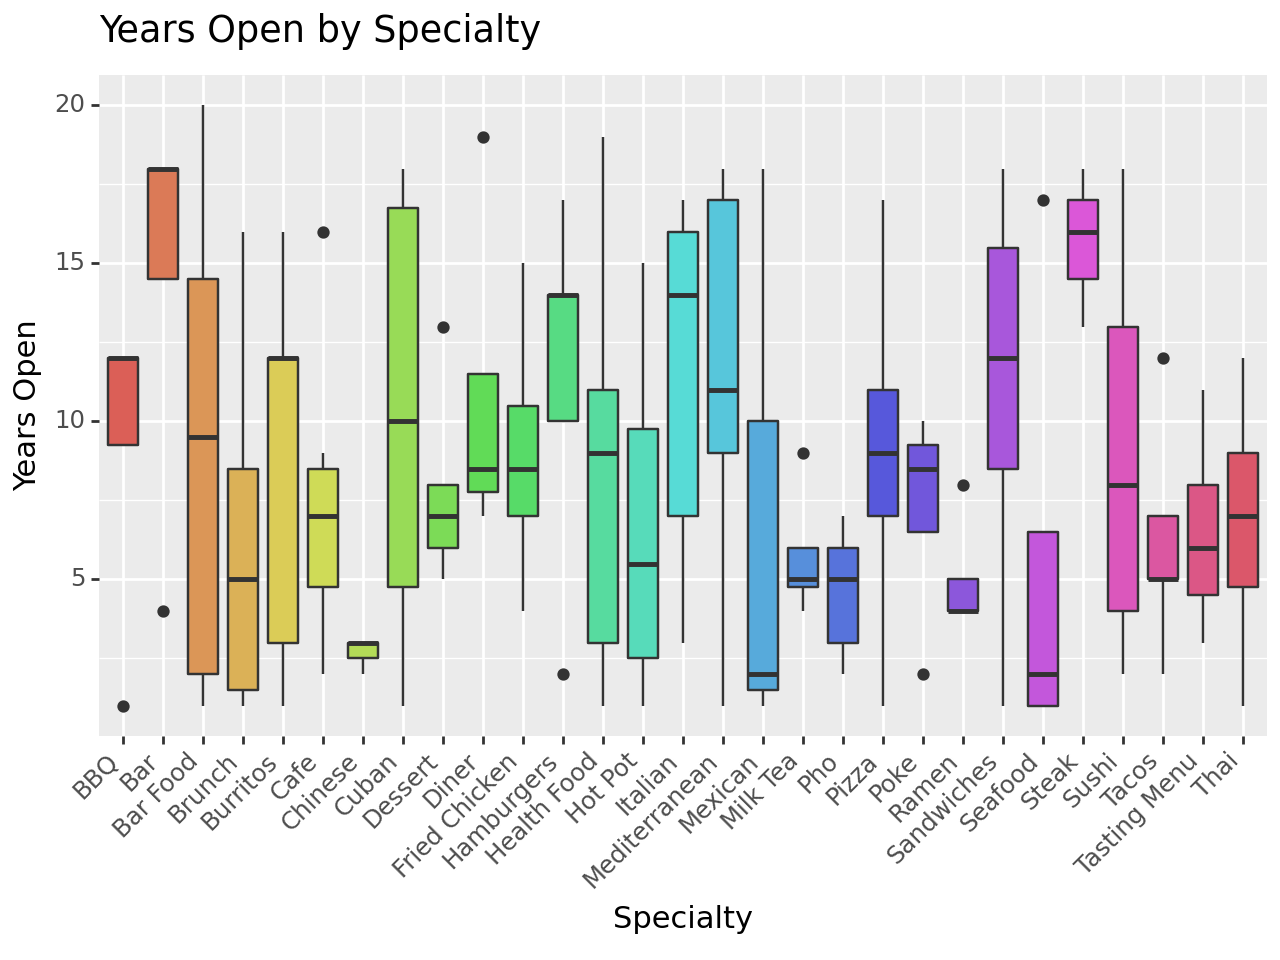

In [27]:
# Create a mapping of dollar categories to price ranges
price_mapping = {
    '$': '$1-15',
    '$$': '$15-50',
    '$$$': '$50-100',
    '$$$$': '$100+'
}

# Apply the mapping to create a new column for plotting
df['PriceRange'] = df['AverageMealPrice'].map(price_mapping)

# Exclude the outlier where "Name" is "The Hobbit"
df_filtered = df[df['Name'] != 'The Hobbit']

p1 = (ggplot(df, aes(x='AlcoholAvailability', y='YearsSinceOpen', fill='AlcoholAvailability')) +
     geom_boxplot() +
      labs(x = "Alcohol Availability", y = "Years Open") +
      ggtitle("Years Open by Alcohol Availability") +
     facet_wrap('~ PriceRange')
     #theme(axis_text_x=element_text(rotation=90, hjust=1))
    )

p1_filtered = (ggplot(df_filtered, aes(x='AlcoholAvailability', y='YearsSinceOpen', fill='AlcoholAvailability')) +
     geom_boxplot() +
      labs(x = "Alcohol Availability", y = "Years Open") +
      ggtitle("Years Open by Alcohol Availability") +
     facet_wrap('~ PriceRange')
     #theme(axis_text_x=element_text(rotation=90, hjust=1))
    )

p2 = (ggplot(df, aes(x='factor(Culture)', y='YearsSinceOpen', fill='Culture')) +
     geom_boxplot() +
      labs(x = "Culture", y = "Years Open") +
      ggtitle("Years Open by Culture") +
     #facet_wrap('~ PriceRange') +
     theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='none')
    )

p2_filtered = (ggplot(df_filtered, aes(x='factor(Culture)', y='YearsSinceOpen', fill='Culture')) +
     geom_boxplot() +
      labs(x = "Culture", y = "Years Open") +
      ggtitle("Years Open by Culture") +
     #facet_wrap('~ PriceRange') +
     theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='none')
    )

p3 = (ggplot(df, aes(x='factor(Specialty)', y='YearsSinceOpen', fill='Specialty')) +
     geom_boxplot() +
      labs(x = "Specialty", y = "Years Open") +
      ggtitle("Years Open by Specialty") +
     #facet_wrap('~ PriceRange') +
     theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='none')
    )

# Create the boxplot with the filtered dataframe
p3_filtered = (ggplot(df_filtered, aes(x='factor(Specialty)', y='YearsSinceOpen', fill='Specialty')) +
      geom_boxplot() +
      labs(x="Specialty", y="Years Open") +
      ggtitle("Years Open by Specialty") +
      theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='none'))


# Display the plots
print(p1)
print(p1_filtered)
print(p2)
print(p2_filtered)
print(p3)
print(p3_filtered)

NOTE WE NEED TO CHANGE THIS SO ITS NOT JUST A BUNCH OF LINES GOING UP AND DOWN

##Q2 (Clustering) Can we identify distinct clusters of restaurants near Chapman University based on their combination of predictors: Rating, DistancefromChapman and AverageMealPrice?

###Variables Involved:
- Rating (Continuous)
- DistancefromChapman (Continuous)
- AverageMealPrice (Categorical)


###Cleaning:
Missing values will be dropped, and reindexed. Standard Scale continous Variables and make Avg Meal Price into numerical categories

###Modeling/Computation:
Make two clustering models K-Means, and Gaussian Mixtures
-  Use the elbow method for K-Means to find the optimal number of clusters.
- For Gaussian Mixtures I use Bayesian Information Criterion (BIC) to choose the optimal number of components (clusters) based on the trade-off between model fit and complexity

###Graphs:
I will make a ggplot for all the data points with different colors representingthe assigned clusters for k means using the combination of all the other predictors. I will see which clustering algorithms were able to best
distinguish from the noise and make good clusters.

###Brief Discussion:
This analysis is effective at answering the question because clustering helps group data points that are similar to each other. It will help find natural grouping restaurants with similar ratings, health inspection results,
distances from Chapman University, and average meal prices. This can help identify distinct categories of restaurants based on these features

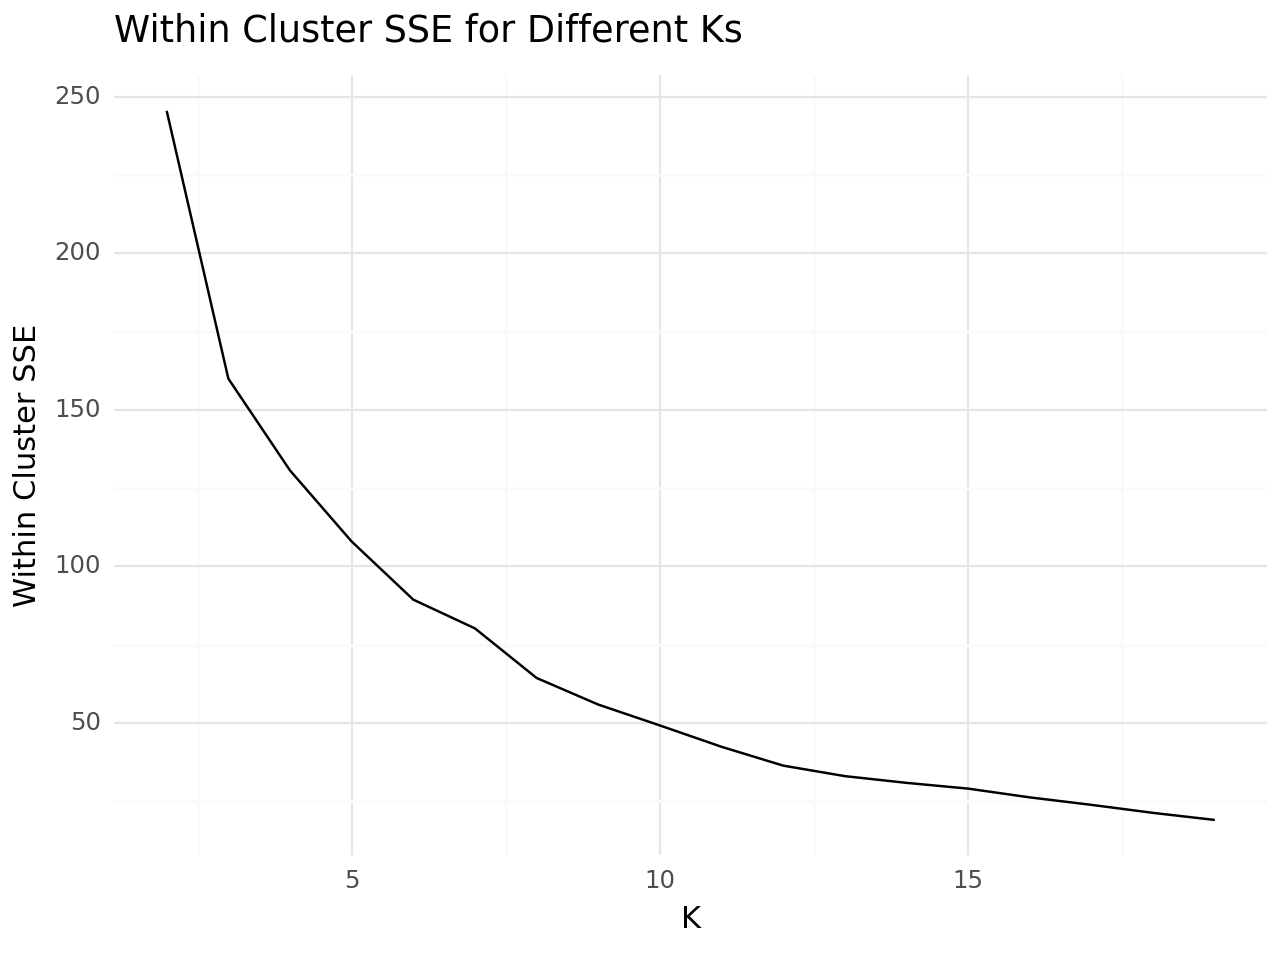

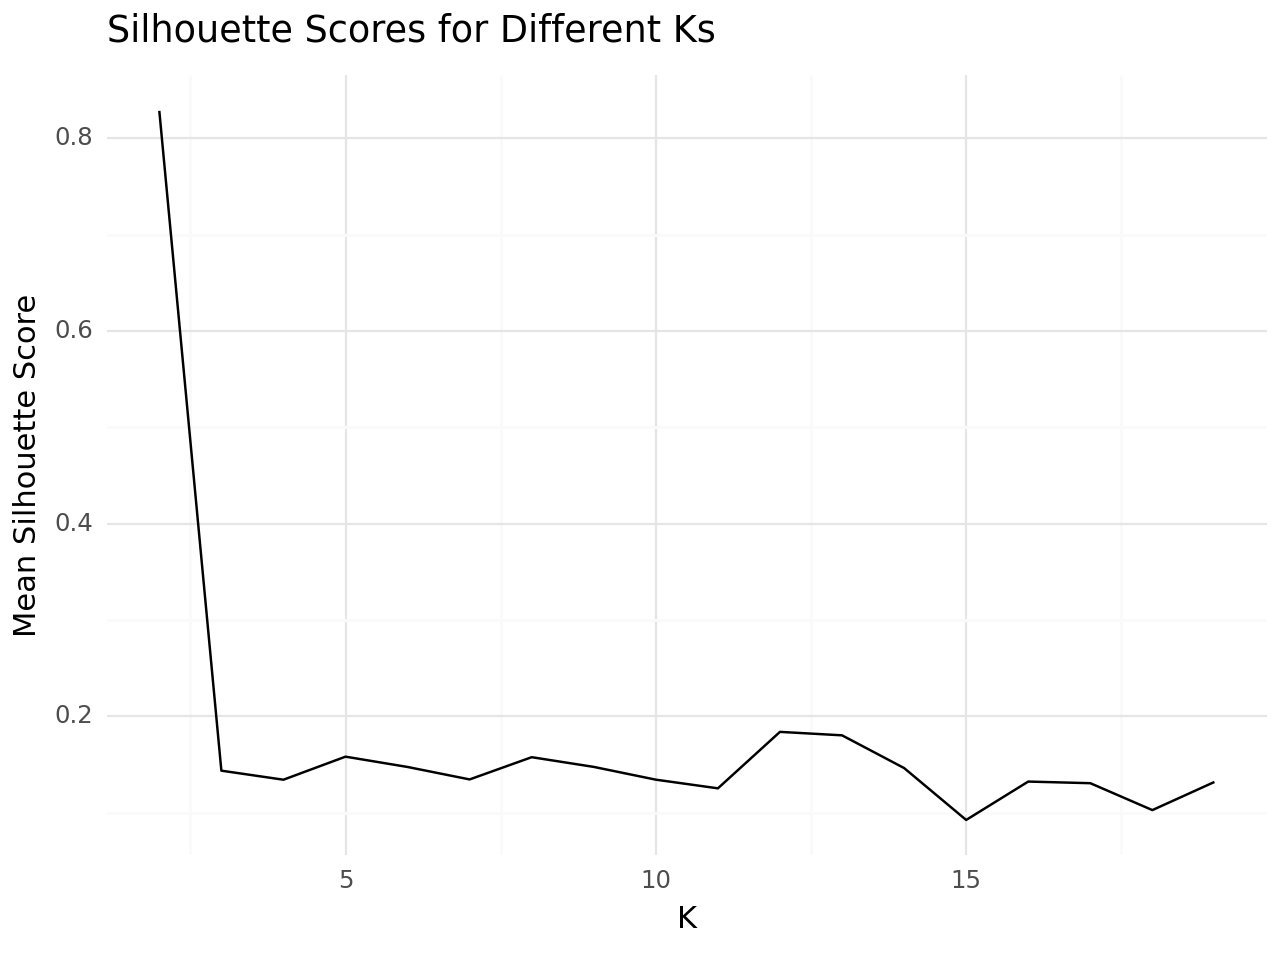


Silhouette Score for KMeans: 0.18749652564544142


In [236]:
data = pd.read_csv("/content/Data Science Final Dataset - Sheet1.csv")

# # # Define mappings
price_range = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
data['AverageMealPrice'] = data['AverageMealPrice'].map(price_range)

# Select predictors and categorical columns
predictors = ["Rating", "DistancefromChapman", "AverageMealPrice"]
contin = ["Rating", "DistancefromChapman"]
categ = ["AverageMealPrice"]

# # Drop missing values and reindex
# data = data.dropna().reset_index(drop=True)

# Extract features
X = data[predictors]

# Define which columns to standardize and which to leave untouched
column_transformer = make_column_transformer(
    (StandardScaler(), contin),  # Columns to standardize
    #(OneHotEncoder(), categ),
    remainder="passthrough"  # Leave other columns untouched
)

metrics = {"SSE": [], "sil": [], "k": []}

for k in range(2, 20):
    kmeans = KMeans(k, random_state=42)
    pipe = Pipeline([
        ("pre", column_transformer),
        ("km", kmeans)
    ])

    labels = pipe.fit_predict(X)
    sil = silhouette_score(X, labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(k)

df = pd.DataFrame(metrics)

print(ggplot(df, aes(x="k", y="SSE")) +
      geom_line() + theme_minimal() +
      labs(x="K", y="Within Cluster SSE", title="Within Cluster SSE for Different Ks"))

print(ggplot(df, aes(x="k", y="sil")) +
      geom_line() + theme_minimal() +
      labs(x="K", y="Mean Silhouette Score", title="Silhouette Scores for Different Ks"))


Silhouette Score for KMeans: 0.18749652564544142


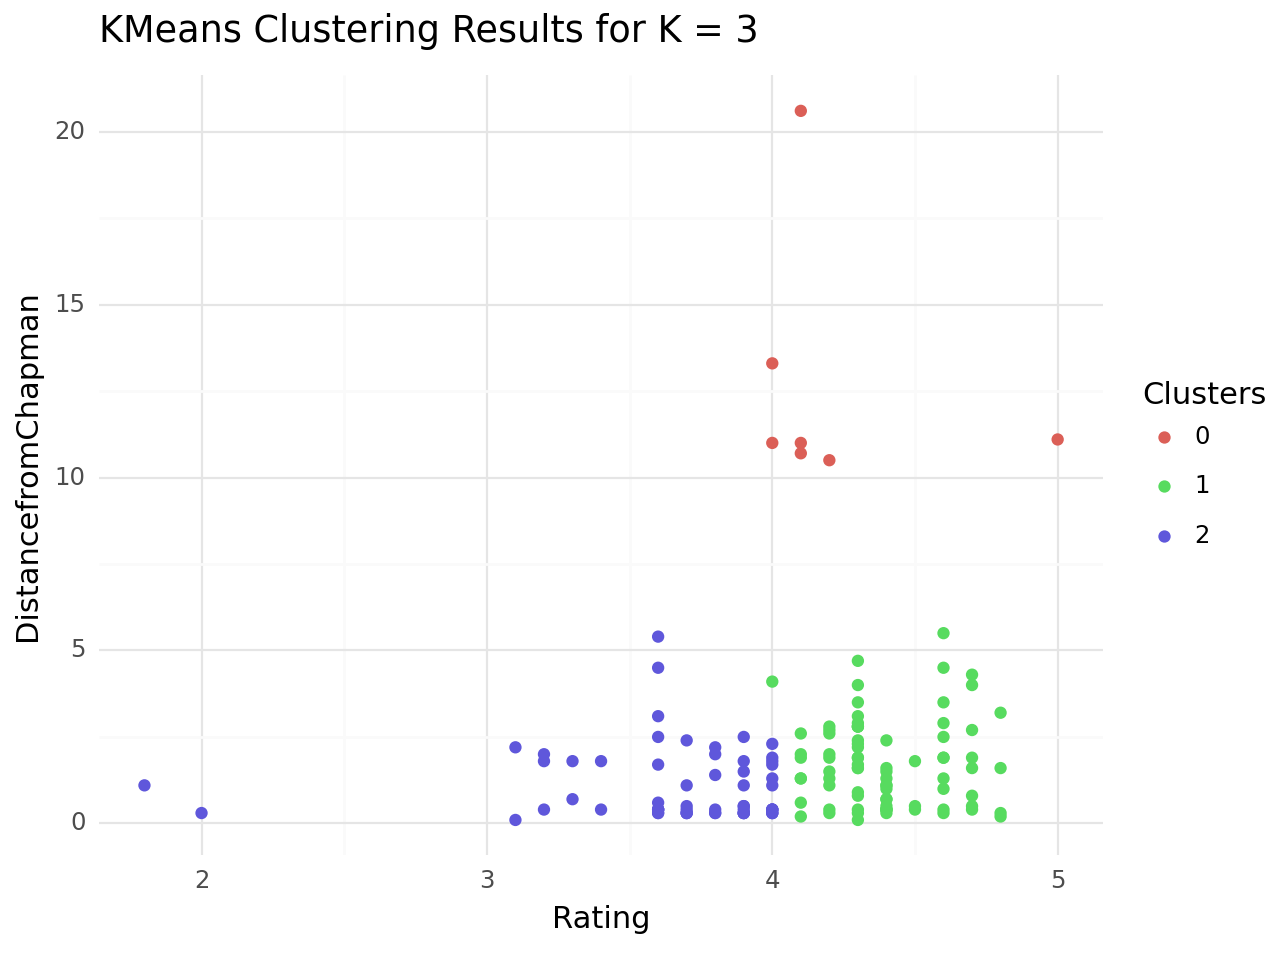

In [238]:
# Perform clustering with KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
pipe_kmeans = Pipeline([
    ("pre", column_transformer),
    ("clust", kmeans)
])

labels_kmeans = pipe_kmeans.fit_predict(X[["Rating", "DistancefromChapman"]])

# Calculate Silhouette Score
silhouette_kmeans = silhouette_score(X[["Rating", "DistancefromChapman"]], labels_kmeans)
print(f"Silhouette Score for KMeans: {silhouette_kmeans}")

# Add cluster labels to the original dataset
data["clusters_kmeans"] = labels_kmeans

# Visualization
plot1 = ggplot(data, aes(x="Rating", y="DistancefromChapman", color="factor(clusters_kmeans)")) + \
    geom_point() + theme_minimal() + \
    labs(x="Rating", y="DistancefromChapman", title="KMeans Clustering Results for K = 3", color="Clusters")

print(plot1)


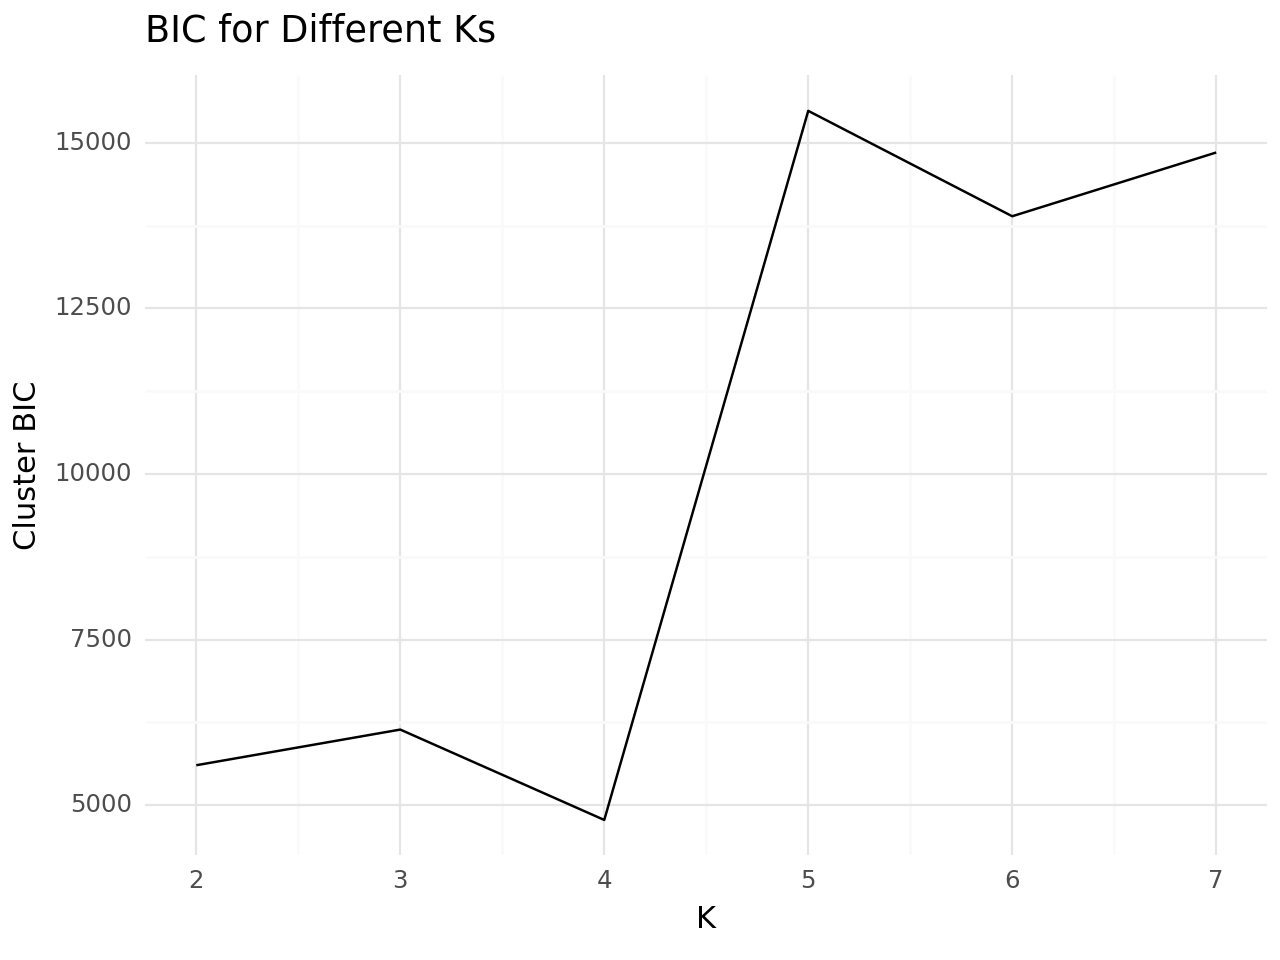


The Silhouette score is: 0.20219382690920243


In [243]:

data = pd.read_csv("/content/Data Science Final Dataset - Sheet1.csv")

# # # Define mappings
price_range = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
data['AverageMealPrice'] = data['AverageMealPrice'].map(price_range)

# # Apply mappings to relevant columns
# data['AverageMealPrice'] = data['AverageMealPrice'].map(price_mapping)

# # Select numerical predictors
# numerical_predictors = ["Rating", "DistancefromChapman", "AverageMealPrice"]

# # Drop missing values and reindex
# data = data.dropna().reset_index(drop=True)

# Extract features
X = data[predictors]

# Define which columns to standardize and which to leave untouched
column_transformer = make_column_transformer(
    (StandardScaler(), contin),  # Columns to standardize
    remainder="passthrough"  # Leave other columns untouched
)

metrics = {"BIC": [], "k": []}

for k in range(2, 8):
    gmm = GaussianMixture(n_components=k)
    pipe = Pipeline([
        ("pre", column_transformer),
        ("gmm", gmm)
    ])

    labels = pipe.fit_predict(X)
    bic_val = pipe.named_steps["gmm"].bic(X)

    metrics["BIC"].append(bic_val)
    metrics["k"].append(k)

df = pd.DataFrame(metrics)

# Plotting BIC
print(ggplot(df, aes(x="k", y="BIC")) +
      geom_line() + theme_minimal() +
      labs(x="K", y="Cluster BIC", title="BIC for Different Ks "))

# GMM Clustering
gmm = GaussianMixture(n_components=4)
pipe_gmm = Pipeline([
    ("pre", column_transformer),
    ("gmm", gmm)
])

labels_gmm = pipe_gmm.fit_predict(X)

silhouette = silhouette_score(X, pipe.predict(X))
print("The Silhouette score is:", silhouette)
data['GMM_Clusters'] = labels_gmm


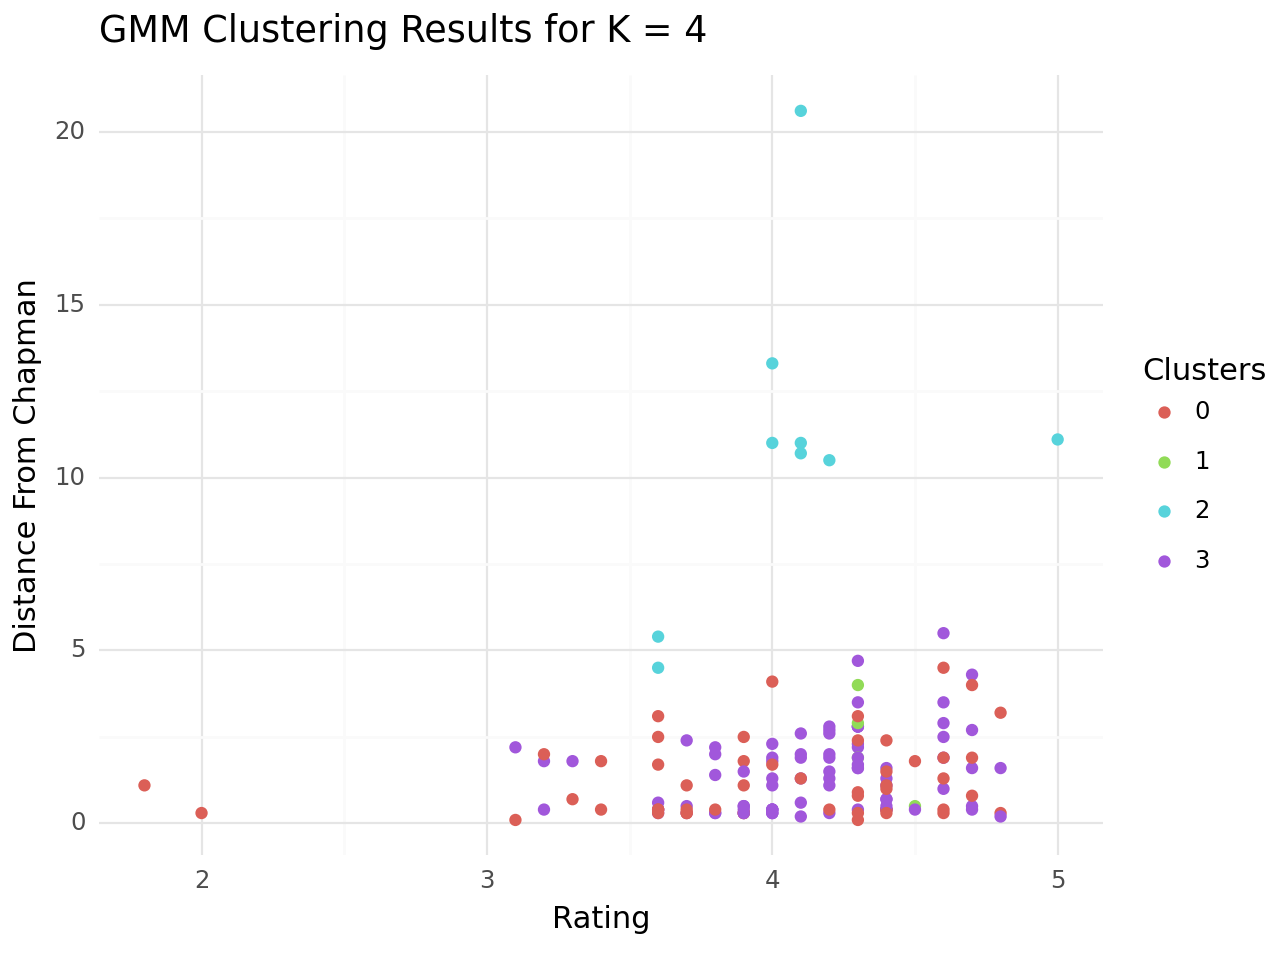

In [244]:
# Plotting clustering results
print(ggplot(data, aes(x="Rating", y="DistancefromChapman", color="factor(GMM_Clusters)")) +
      geom_point() + theme_minimal() +
      labs(x="Rating", y="Distance From Chapman",
           title=f"GMM Clustering Results for K = {4}",
           color="Clusters"))

##Q3: Impact of Culture and Specialty on Ratings and Reviews##
##Analyze how a restaurant's cultural background, specialty food type, and number of reviews affect its ratings.##

###Variables:
- Culture (Categorical)
- Specialty (Categorical)
- Reviews (Continuous)
- Predicting: Rating (Interval)

###Cleaning and Preprocessing:
- Handle missing values.
- Use OneHotEncoder() for categorical variables.
- Use StandardScaler() to z score continuous variables.

###Modeling/Computation:
- Utilize a supervised model: Random Forest and use Grid Search to find ideal hyperparameters
- A Train/Test split with 80/20 split.

###Graphs:
- Box plot that shows the Rating for each Culture
- Scatterplot that shows Reviews on X Axis, and Rating on Y Axis
- Box plot that shows the Rating for each Specialty

###Brief Discussion:
We utilize a supervised linear regression model to investigate how a restaurant's cultural
background, specialty food type, and number of reviews influence its rating. The analysis, visualized
via box plots and bar graphs, reveals how different cultures and specialties correlate with
customer ratings, providing valuable insights into customer preferences and satisfaction trends.

In [ ]:
# QUESTION 3

# drop missing values
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.isnull().sum()

predictors = [
    "Culture",
    "Specialty",
    "Reviews"
]

categ = [
    "Culture",
    "Specialty"
]

contin = [
    "Reviews"
]

X = df[predictors]
y = df['Rating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# z score
preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categ),
                                     (StandardScaler(), contin),
                                     remainder = "passthrough")

#model_name = "Random Forest"

# Linear Regression does not work well
# Lasso and Ridge do not work well either

# create model
#model = KNeighborsRegressor()
# KNN does not work well either

# Define the parameter grid:
# param_grid = {
#     'model__n_estimators': [50, 100, 150],  # Number of boosting stages to be run
#     'model__max_depth': [3, 4, 5, 6],  # Maximum depth of the individual regression estimators
#     'model__learning_rate': [0.01, 0.05, 0.1],  # Learning rate shrinks the contribution of each tree
#     'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'model__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
#     #'model__max_features': ['auto', 'sqrt', 'log2']  # The number of features to consider when looking for the best split
#     #'model__subsample': [0.8, 1.0]  # The fraction of samples to be used for fitting the individual base learners
# }
# param_grid = {
#     'model__n_estimators': [10, 50, 100],  # Number of trees in the forest
#     'model__max_depth': [10, 20, 30],  # Maximum depth of the tree
#     'model__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
#     'model__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
#     'model__max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
#     'model__bootstrap': [True, False]  # Method of selecting samples for training each tree
# }

# param_grid = {
#     'model__max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
#     'model__min_samples_split': [2, 5, 10, 15],  # Minimum number of samples required to split a node
#     'model__min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required at each leaf node
#     'model__max_features': ['auto', 'sqrt', 'log2', None],  # Number of features to consider at every split
#     'model__min_impurity_decrease': [0.0, 0.01, 0.02, 0.05]  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
# }

model = RandomForestRegressor(bootstrap = True,
                              max_depth = 10,
                              max_features = 'sqrt',
                              min_samples_leaf = 1,
                              min_samples_split = 2,
                              n_estimators = 50)

pipe3 = Pipeline([("pre", preprocess),
                  #("poly", PolynomialFeatures(degree = 2)),
                 ("model", model)])

# # Setup the grid search
# grid_search = GridSearchCV(pipe3, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # View the best parameters
# best_parameters = grid_search.best_params_
# print("Best Parameters: ", best_parameters)

# # Use the best estimator
# best_model = grid_search.best_estimator_

# # Assess performance on both the training and test sets
# y_pred_train = best_model.predict(X_train)
# y_pred_test = best_model.predict(X_test)

# train_r2 = r2_score(y_train, y_pred_train)
# test_r2 = r2_score(y_test, y_pred_test)

# print("Train R2: ", train_r2)
# print("Test R2: ", test_r2)


# fit
pipe.fit(X_train,y_train)

# predict
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# assess
print("This is for a Random Forest\n")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))


This is for a Random Forest

Train MSE :  0.04090220993151621
Train MAE :  0.15872058855649837
Train MAPE:  0.04068544276896231
Train R2  :  0.8176211542023799

Test MSE  :  0.18676130392458948
Test MAE  :  0.34152914542091406
Test MAPE :  0.08963332308516755
Test R2   :  0.14246633573730638


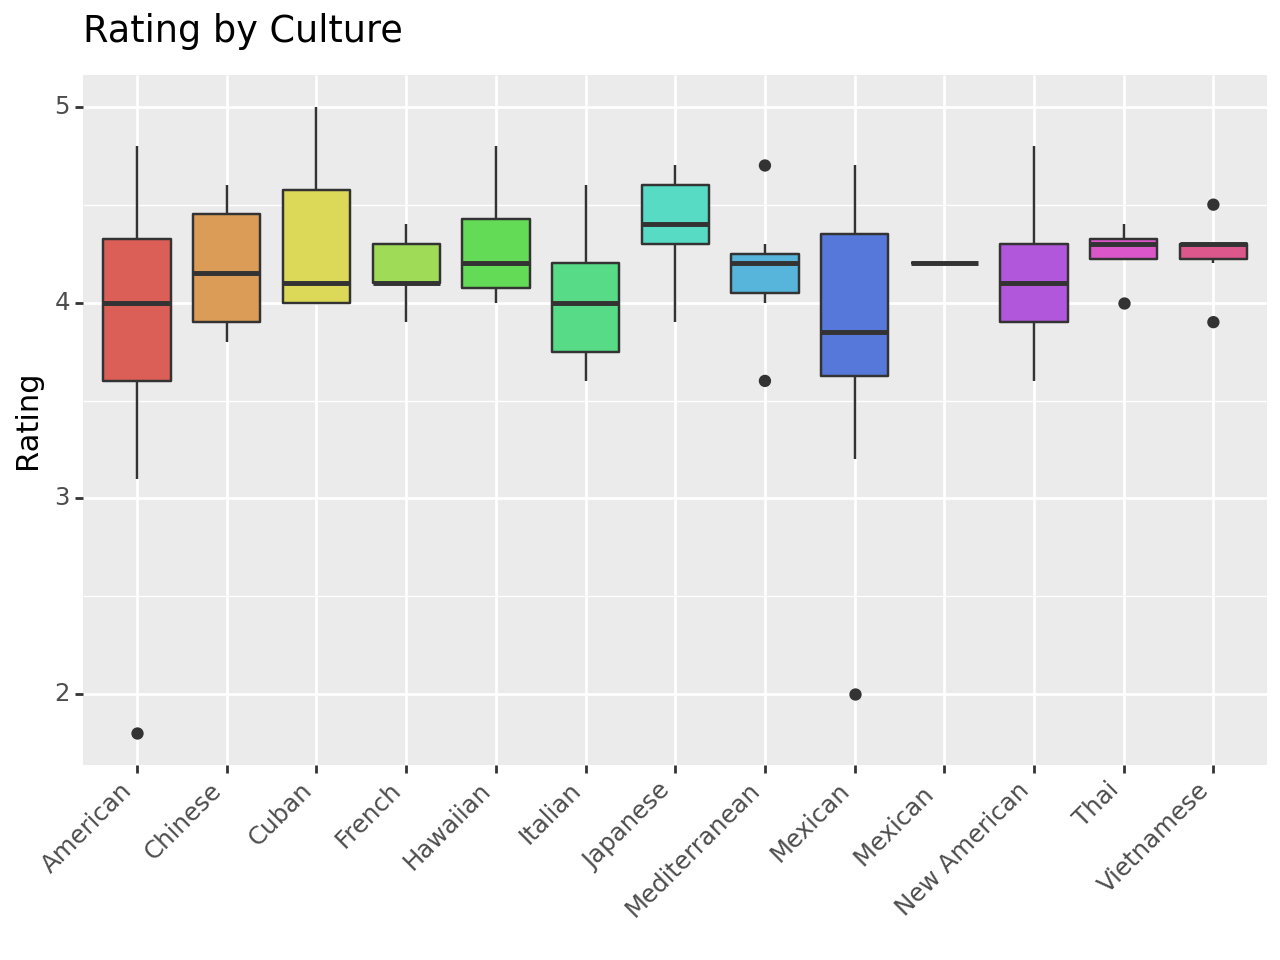

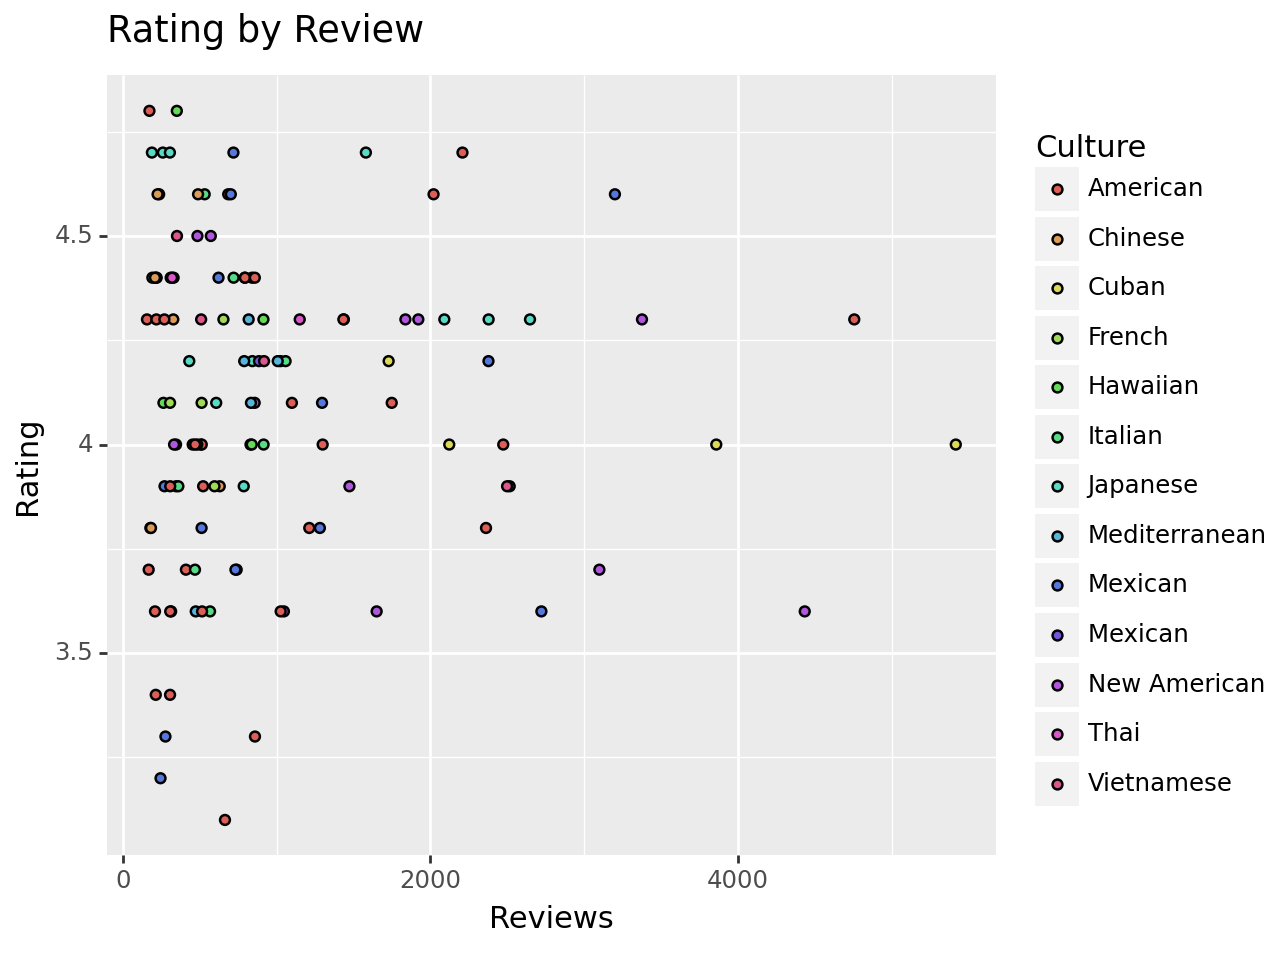

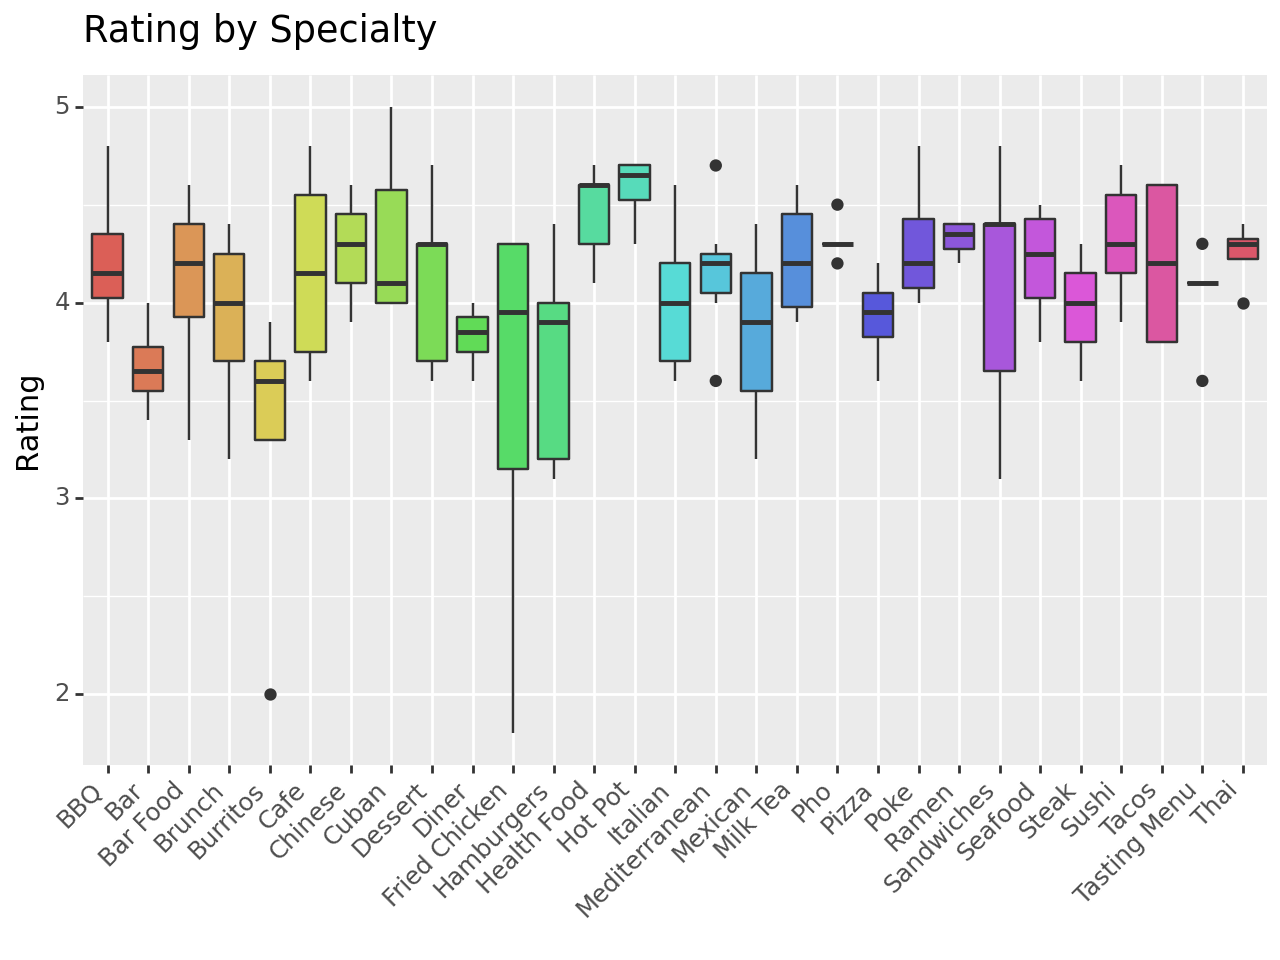

In [29]:

p1 = (ggplot(df, aes(x='factor(Culture)', y='Rating', fill='Culture')) +
     geom_boxplot() +
      labs(x = "", y = "Rating") +
      ggtitle("Rating by Culture") +
     #facet_wrap('~ PriceRange') +
     theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='none')
    )

# Assuming 'df' is your original DataFrame
new_df = df[df['Reviews'] > 150]


# TODO: Possibly deshit this graph
p2 = (ggplot(new_df, aes(x='Reviews', y='Rating', fill='Culture')) +
     geom_point() +
      labs(x = "Reviews", y = "Rating") +
      ggtitle("Rating by Review")
     #theme(axis_text_x=element_text(rotation=90, hjust=1))
    )

p3 = (ggplot(df, aes(x='factor(Specialty)', y='Rating', fill='Specialty')) +
     geom_boxplot() +
      labs(x = "", y = "Rating") +
      ggtitle("Rating by Specialty") +
     #facet_wrap('~ PriceRange') +
     theme(axis_text_x=element_text(rotation=45, hjust=1), legend_position='none')
    )

# Display the plots
#print(p1)
print(p1)
print(p2)
print(p3)

##Q4: (Clustering) How does the proximity to Chapman University affect restaurant success?
###Variables:
- Distance (Continuous)
- Success (Continuous) = Rating * Reviews

###Cleaning and Preprocessing:
- Handle missing values.
- StandardScaler() to Z Score continuous variables

###Modeling/Computation:
- Apply a clustering algorithm like K-Means or Hierarchical Clustering. (Or other depending on how the data is and which would be appropriate)
- Define 'success' as high ratings and focus the analysis on restaurants meeting these criteria.

###Graphs:
- BIC Graph or dendrograms to show how restaurants group together based on shared
characteristics.
- Scatter plots to visualize clusters.

###Brief Discussion:
We use a clustering algorithm like K-Means or Hierarchical Clustering to identify the common
traits of successful restaurants, defined by high ratings. After preprocessing data with
OneHotEncoder and Z-score normalization, the research uncovers patterns in factors like culture,
specialty, and alcohol availability, visualized through BIC graphs or dendrograms and scatter
plots, offering strategic insights into the key attributes of successful restaurant operations.

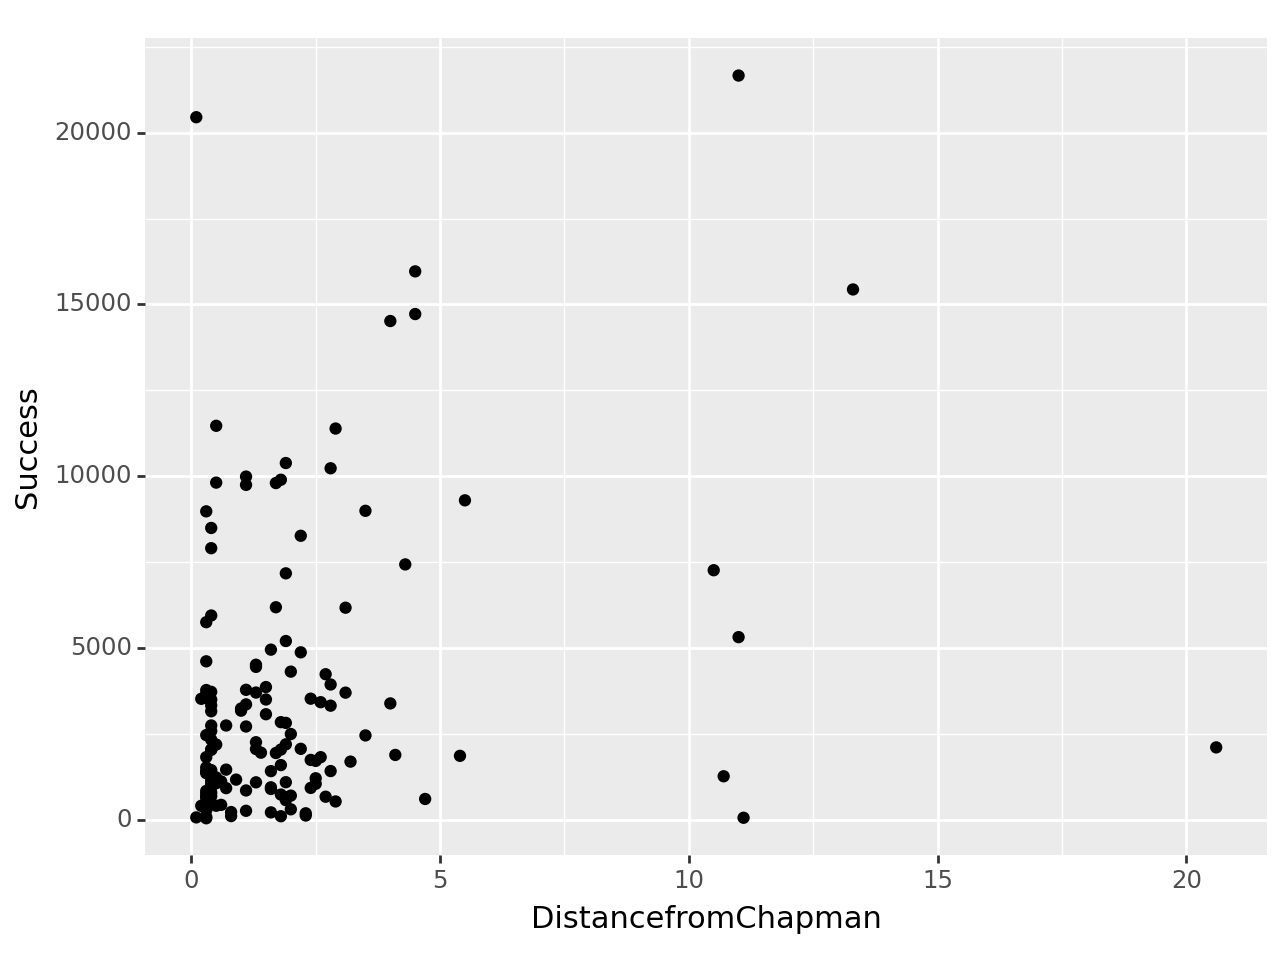

In [ ]:
from sys import ps2
# code for Q4

df['Success'] = df['Rating'] * df['Reviews']


p2 = (ggplot(df) +
     aes(x='DistancefromChapman', y = 'Success') +
     geom_point())

print(p2)


Optimal number of clusters (k) according to BIC: 6


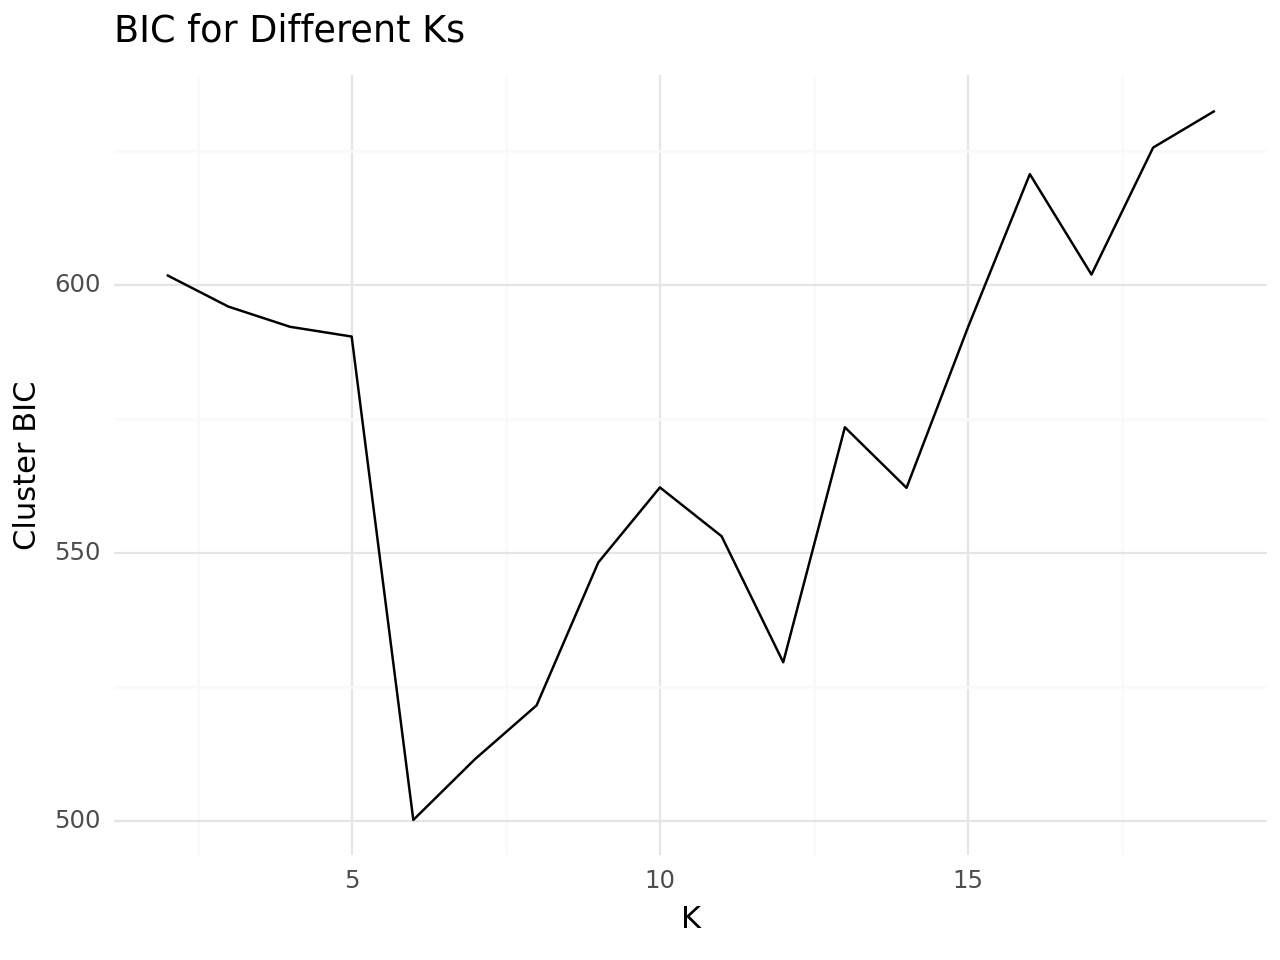

In [ ]:
# Q4 using GMM

feats = ['Success', 'DistancefromChapman']

X = df[feats]

# create empty model
z = make_column_transformer((StandardScaler(), feats),
                            remainder = "passthrough")

metrics = {"BIC": [], "k": []}

for i in range(2,20):
    gmm = GaussianMixture(i)
    pipe = Pipeline([
        ("pre", z),
        ("gmm", gmm)
    ])

    pipe.fit(X) # Fit the pipeline, which includes the GMM
    transformed_data = pipe.named_steps["pre"].transform(X) # Transform the data using the preprocessor
    bic_val = pipe.named_steps["gmm"].bic(transformed_data) # Calculate the BIC on the transformed data
    # labels = pipe.fit_predict(X[feats])
    # bic_val = pipe.named_steps["gmm"].bic(X[feats])

    metrics["BIC"].append(bic_val)
    metrics["k"].append(i)

df_metrics = pd.DataFrame(metrics)

# Find the index of the minimum BIC value
min_bic_index = df_metrics['BIC'].idxmin()

# Print the corresponding value of "k" (number of clusters)
print("Optimal number of clusters (k) according to BIC:", df_metrics.at[min_bic_index, 'k'])

print(ggplot(df_metrics, aes(x = "k", y = "BIC")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Cluster BIC",
         title = "BIC for Different Ks"))

# use n=6 based on graph

Silhouette Score: 0.3771165884708617


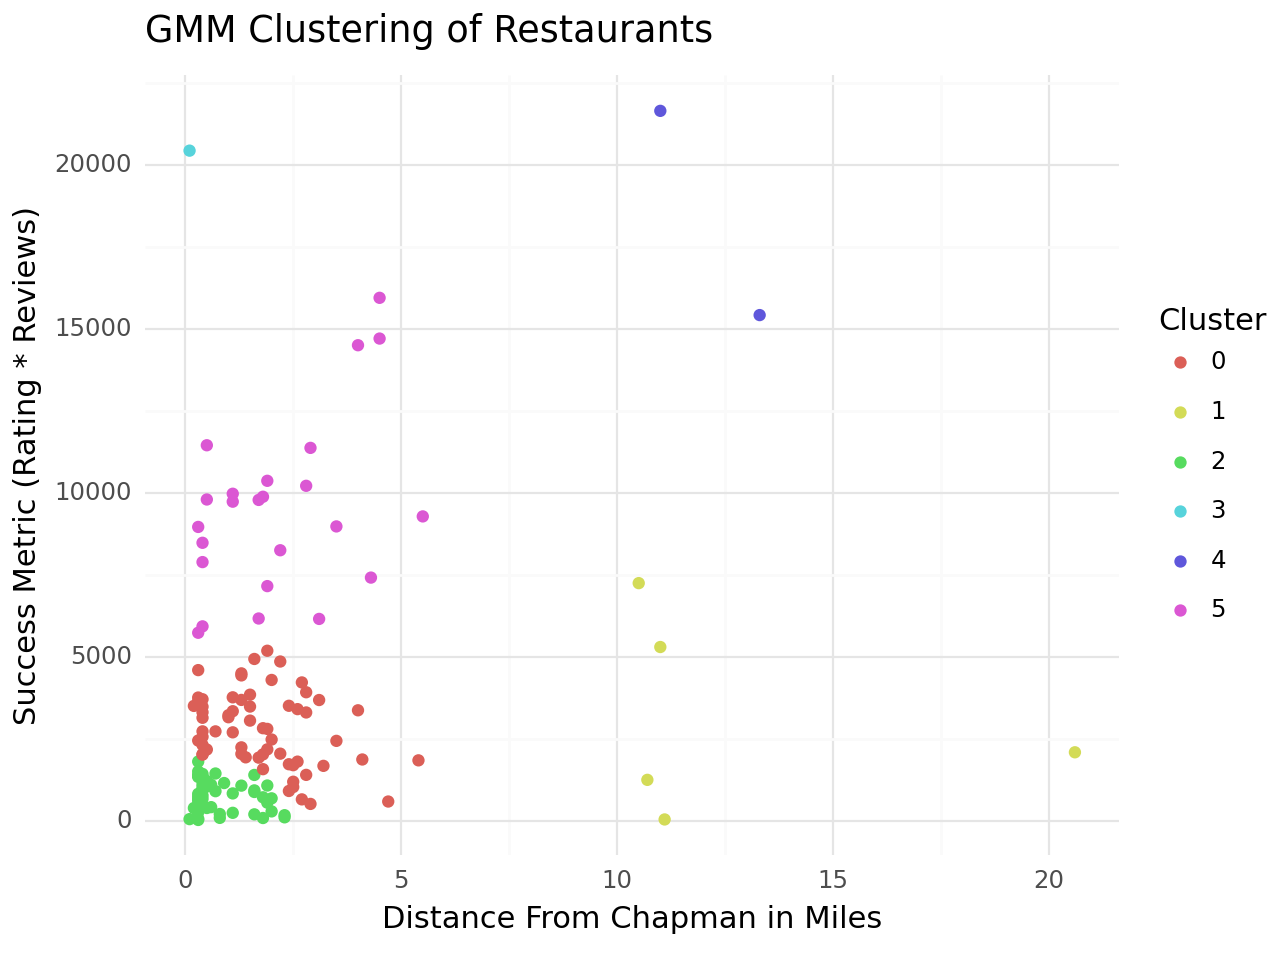

In [ ]:
gmm = GaussianMixture(n_components=6)
pipe = Pipeline([
    ("pre", z),
    ("gmm", gmm)
])
labels = pipe.fit_predict(X[['Success', 'DistancefromChapman']])

X["cluster"] = labels

silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score: " + str(silhouette_avg))

print(ggplot(X, aes(x='DistancefromChapman', y='Success', color="factor(cluster)")) +
      geom_point() +
      theme_minimal() +
      scale_color_discrete(name="Cluster") +
      labs(x="Distance From Chapman in Miles",
           y="Success Metric (Rating * Reviews)",
           title="GMM Clustering of Restaurants"))


##Q5: (Supervised Model and Dimensionality Reduction via LASSO) Influence of Meal Price and Alcohol Availability on Ratings
##Investigate the effect of average meal price and alcohol availability on ratings.
###Variables:
- Average Meal Price (Categorical)
- AlcoholAvailability (Categorical)
- Ratings (Interval)

###Cleaning and Preprocessing:
- Handle missing values.
- OneHotEncoder() for Categorical.

###Modeling/Computation:
- Use a supervised model with dimensionality reduction to predict complex relationships such as a Ridge or Lasso
- Train/Test split of 80-20 for model validation.

###Graphs:
- Box plot that shows price ranges on x axis and rating on y axis
- Box plot that shows alcohol availability on x axis and rating on y axis

###Brief Discussion:
This study employs a Gradient Boosting Tree model to explore the complex relationship between
average meal price, restaurant specialty, and customer ratings. This analysis can provide insights
into how pricing strategy and culinary focus influence customer satisfaction, aiding in strategic
decision-making.

In [142]:
# Q5

# drop missing
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)

# X and y
predictors = [
    "AverageMealPrice",
    "AlcoholAvailability"
]
categ = predictors

X = df[predictors]
y = df["Rating"]

# model
pre = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), categ),
                            remainder = "passthrough")

# NOTE: All 3 Tree models are not good
#model = GradientBoostingRegressor()

#model = KNeighborsRegressor()

model = LinearRegression()

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

pipe = Pipeline([("zscore", pre),
                 ("poly", PolynomialFeatures(degree = 1)),
                ("linearregression", model)])

# # fit
# pipe.fit(X_train,y_train)

# # predict
# y_pred_train = pipe.predict(X_train)
# y_pred_test = pipe.predict(X_test)

# # assess
# print("THIS IS FOR LINEAR REGRESSION\n")
# print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
# print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
# print("Train MAPE: ", mean_absolute_percentage_error(y_train,y_pred_train))
# print("Train R2  : ", r2_score(y_train,y_pred_train))
# print()
# print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
# print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
# print("Test MAPE : ", mean_absolute_percentage_error(y_test,y_pred_test))
# print("Test R2   : ", r2_score(y_test,y_pred_test))

# validation
kf = KFold(5)

mse = {"train": [], "test": []}
mae = {"train": [], "test": []}
mape = {"train": [], "test": []}
r2 = {"train": [], "test": []}

for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y[train]
    y_test  = y[test]

    # fit
    pipe.fit(X_train,y_train)

    # predict
    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    # assess
    mse["train"].append(mean_squared_error(y_train,y_pred_train))
    mse["test"].append(mean_squared_error(y_test,y_pred_test))

    mae["train"].append(mean_absolute_error(y_train,y_pred_train))
    mae["test"].append(mean_absolute_error(y_test,y_pred_test))

    mape["train"].append(mean_absolute_percentage_error(y_train,y_pred_train))
    mape["test"].append(mean_absolute_percentage_error(y_test,y_pred_test))

    r2["train"].append(r2_score(y_train,y_pred_train))
    r2["test"].append(r2_score(y_test,y_pred_test))

print("Train MSE :", np.mean(mse["train"]))
print("Test MSE  :", np.mean(mse["test"]))
print()

print("Train MAE :", np.mean(mae["train"]))
print("Test MAE  :", np.mean(mae["test"]))
print()

print("Train MAPE :", np.mean(mape["train"]))
print("Test MAPE  :", np.mean(mape["test"]))
print()

print("Train R2 :", np.mean(r2["train"]))
print("Test R2  :", np.mean(r2["test"]))

Train MSE : 0.20941321748915165
Test MSE  : 0.24348608649819056

Train MAE : 0.3303049282857581
Test MAE  : 0.3604851042518685

Train MAPE : 0.09010974485737942
Test MAPE  : 0.09828157737397232

Train R2 : 0.058584492284406875
Test R2  : -0.2276442340745864


In [144]:
# Create a pipeline with preprocessing and LassoCV
pipe = Pipeline([("pre", pre),
                 ("poly", PolynomialFeatures(degree = 2)),
                ("lasso", LassoCV(cv=5))])

alpha_value = 1.0

# # Create a pipeline with preprocessing and Ridge
# pipe = Pipeline([
#     ("pre", pre),
#     ("poly", PolynomialFeatures(degree=2)),
#     ("lasso", Lasso(alpha=alpha_value))  # Use Ridge with the specified alpha
# ])

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# Fit the pipeline (LassoCV will find the best alpha value)
pipe.fit(X_train, y_train)

# # Access the best alpha value
best_alpha = pipe.named_steps['lasso'].alpha_

# Predict using the model
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Assess the model's performance
print("This is for Lasso with alpha = ", str(best_alpha), "\n")
print("Train MSE : ", mean_squared_error(y_train, y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train, y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train, y_pred_train))
print("Train R2  : ", r2_score(y_train, y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test, y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test, y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test, y_pred_test))
print("Test R2   : ", r2_score(y_test, y_pred_test))

This is for Lasso with alpha =  0.025984367010007416 

Train MSE :  0.23451822631309796
Train MAE :  0.3489809335963181
Train MAPE:  0.09674733388167048
Train R2  :  7.771561172376096e-16

Test MSE  :  0.18332507853020663
Test MAE  :  0.35501424501424506
Test MAPE :  0.0941126598874184
Test R2   :  -0.12385103655872243


In [199]:
ALPHA = 9.5
# Create a pipeline with preprocessing and RidgeCV
pipe = Pipeline([("pre", pre),
                 #("poly", PolynomialFeatures(degree = 3)),
                #("ridge", Ridge(alpha=ALPHA))])
                ("ridge", RidgeCV(cv=5))])

# split into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

# Fit the pipeline (RidgeCV will find the best alpha value)
pipe.fit(X_train, y_train)

# Access the best alpha value
best_alpha = pipe.named_steps['ridge'].alpha_

# Predict using the model
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Assess the model's performance
print("This is for Ridge with alpha = ", str(best_alpha), "\n")
print("Train MSE : ", mean_squared_error(y_train, y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train, y_pred_train))
print("Train MAPE: ", mean_absolute_percentage_error(y_train, y_pred_train))
print("Train R2  : ", r2_score(y_train, y_pred_train))
print()
print("Test MSE  : ", mean_squared_error(y_test, y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test, y_pred_test))
print("Test MAPE : ", mean_absolute_percentage_error(y_test, y_pred_test))
print("Test R2   : ", r2_score(y_test, y_pred_test))

This is for Ridge with alpha =  10.0 

Train MSE :  0.22630295308200793
Train MAE :  0.3436172742914211
Train MAPE:  0.09517802749300817
Train R2  :  0.027807025506277006

Test MSE  :  0.15441854679446382
Test MAE  :  0.3206745247487663
Test MAPE :  0.07997007898449567
Test R2   :  0.10075505004104623


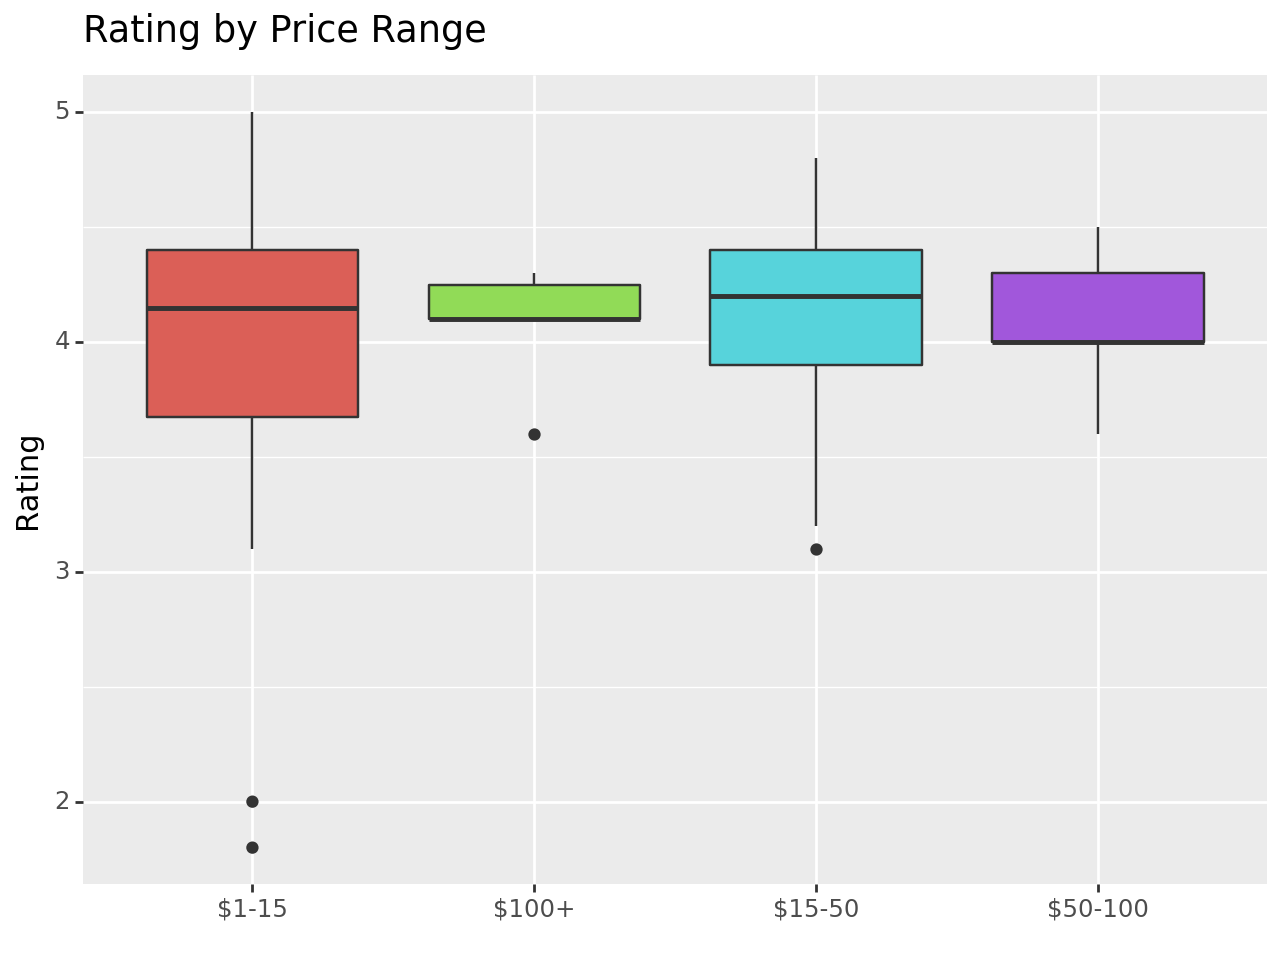

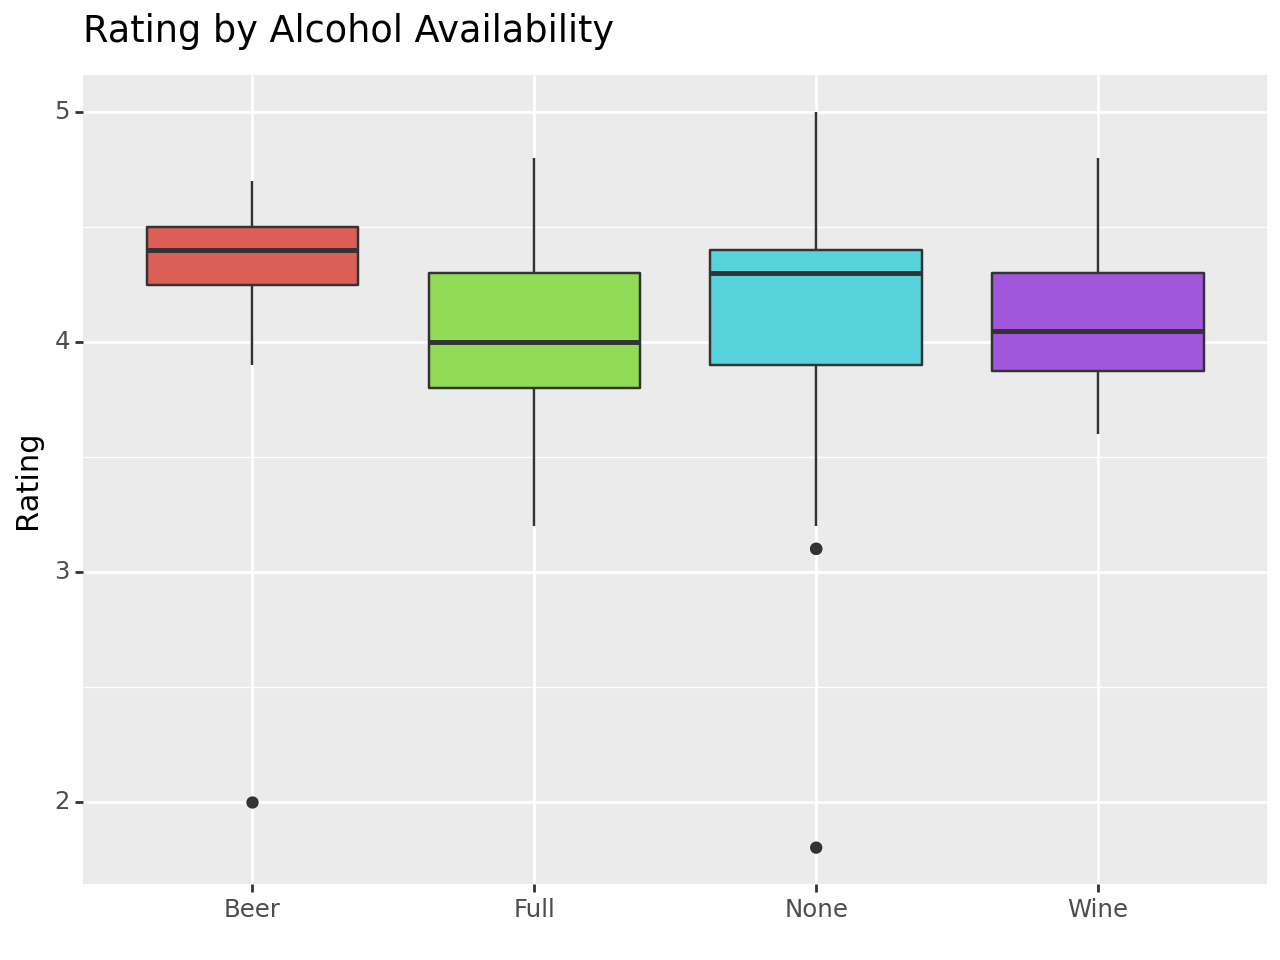

In [201]:
# Create a mapping of dollar categories to price ranges
price_mapping = {
    '$': '$1-15',
    '$$': '$15-50',
    '$$$': '$50-100',
    '$$$$': '$100+'
}

# Apply the mapping to create a new column for plotting
df['PriceRange'] = df['AverageMealPrice'].map(price_mapping)

p1 = (ggplot(df, aes(x='factor(PriceRange)', y='Rating', fill='PriceRange')) +
     geom_boxplot() +
      labs(x = "", y = "Rating") +
      ggtitle("Rating by Price Range") +
     #facet_wrap('~ PriceRange') +
     theme(legend_position='none')
    )

# TODO: Possibly deshit this graph
p2 = (ggplot(df, aes(x='AlcoholAvailability', y='Rating', fill='AlcoholAvailability')) +
     geom_boxplot() +
      labs(x = "", y = "Rating") +
      ggtitle("Rating by Alcohol Availability") +
     theme(legend_position='none')
    )

# Display the plots
#print(p1)
print(p1)
print(p2)

##Q6: Feature Importance on Average Meal Price

##Examine most important features that predict average meal price at a restaurant near Chapman University
###Variables:
- Average Meal Price (numerical categories)
- RestaurantType (Categorical)
- Culture (Categorical)
- Specialty (Categorical)
- Alcohol Availability( Categorical)
- Rating (Continuous)
- CompetitorDensity (Continuous)
- YearsSinceOpen (Continuous)
- Reviews (Continuous)
- DistancefromChapman (Continuous)


###Cleaning and Preprocessing:
- Handle missing values.
- OneHotEncoder() for categorical variables.
- Z Score Continuous

###Modeling/Computation:
- Feature Engineering to create a new column/variable of competiveness that will comprise of competitor density and ratings/reviews.
- Utilize a Random Forest Model to find most important features
- Use model to predict what are the most important features for predicting average meal price

###Graphs:

In the provided code, you employed the ggplot library to create two distinct types of visualizations based on the Grammar of Graphics principles. The first plot is a detailed scatter plot depicting the relationship between the most important feature most_important_feature and the DistancefromChapman. The points in the scatter plot are colored according to the AverageMealPrice, providing a visual representation of how these variables interact. The second plot is a bar plot showcasing the top 5 features with the highest importance in predicting AverageMealPrice. The bars are sorted in descending order based on feature importance, and their colors distinguish between different features. These visualizations offer an insightful exploration of the relationships and predictive capabilities of the selected features, adhering to the modular and customizable nature of the Grammar of Graphics approach.

###Brief Discussion:
In this feature importance analysis for predicting average meal prices at restaurants near Chapman University, a diverse set of variables, including categorical and continuous features, was considered. Data preprocessing involved handling missing values, applying OneHotEncoder to categorical variables, and standardizing continuous variables with Z-score normalization.

To predict average meal prices, a Random Forest model was trained, and feature engineering created a new competitiveness metric. Two key visualizations were generated using ggplot. The first was a detailed scatter plot illustrating the relationship between the most important feature and distance from Chapman, with color coding indicating average meal prices. The second was a bar chart highlighting the top 5 features with the highest importance in predicting average meal prices.

These visualizations provide a nuanced understanding of feature relationships and predictive capabilities. The modular and customizable nature of ggplot facilitated the creation of insightful visualizations, aiding in the interpretation of model results and feature importance.

Training Set:
Mean Squared Error: 0.03229850957123684
R-squared: 0.9413925904665084

Testing Set:
Mean Squared Error: 0.11997520661157024
R-squared: 0.5001033057851241
                       Feature  Importance
46      Specialty_Tasting Menu    0.218752
49    AlcoholAvailability_None    0.193852
2                      Reviews    0.148193
0          DistancefromChapman    0.136304
1                       Rating    0.050840
3            CompetitorDensity    0.045611
4               YearsSinceOpen    0.027689
45             Specialty_Tacos    0.026140
17        Culture_New American    0.020401
20               Specialty_Bar    0.019026
41        Specialty_Sandwiches    0.016181
43             Specialty_Steak    0.011818
42           Specialty_Seafood    0.007365
7        RestaurantType_Single    0.005761
25           Specialty_Chinese    0.005582
40             Specialty_Ramen    0.005391
10              Culture_French    0.004766
37               Specialty_Pho    0.004761
16            C

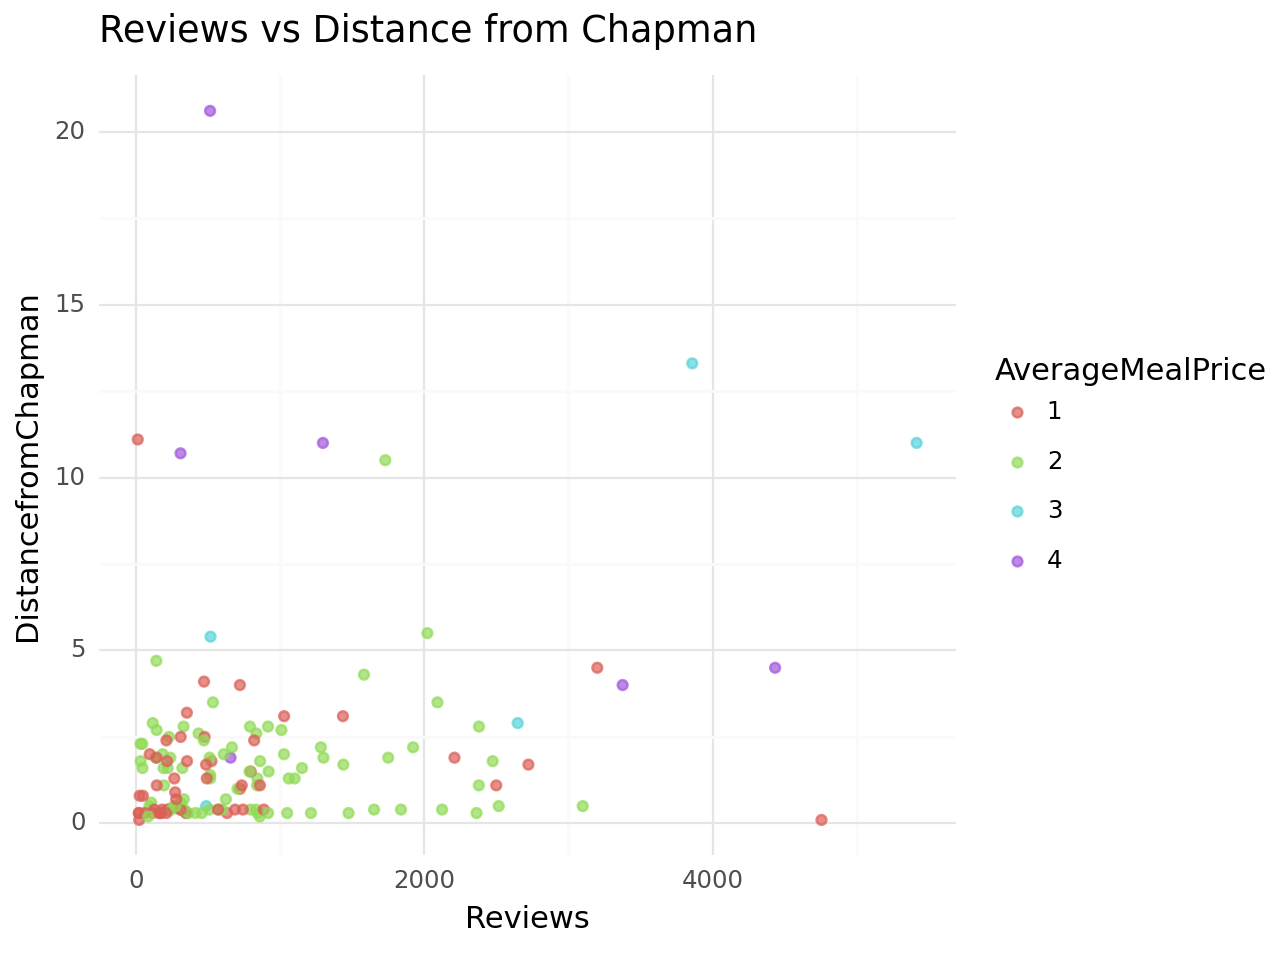

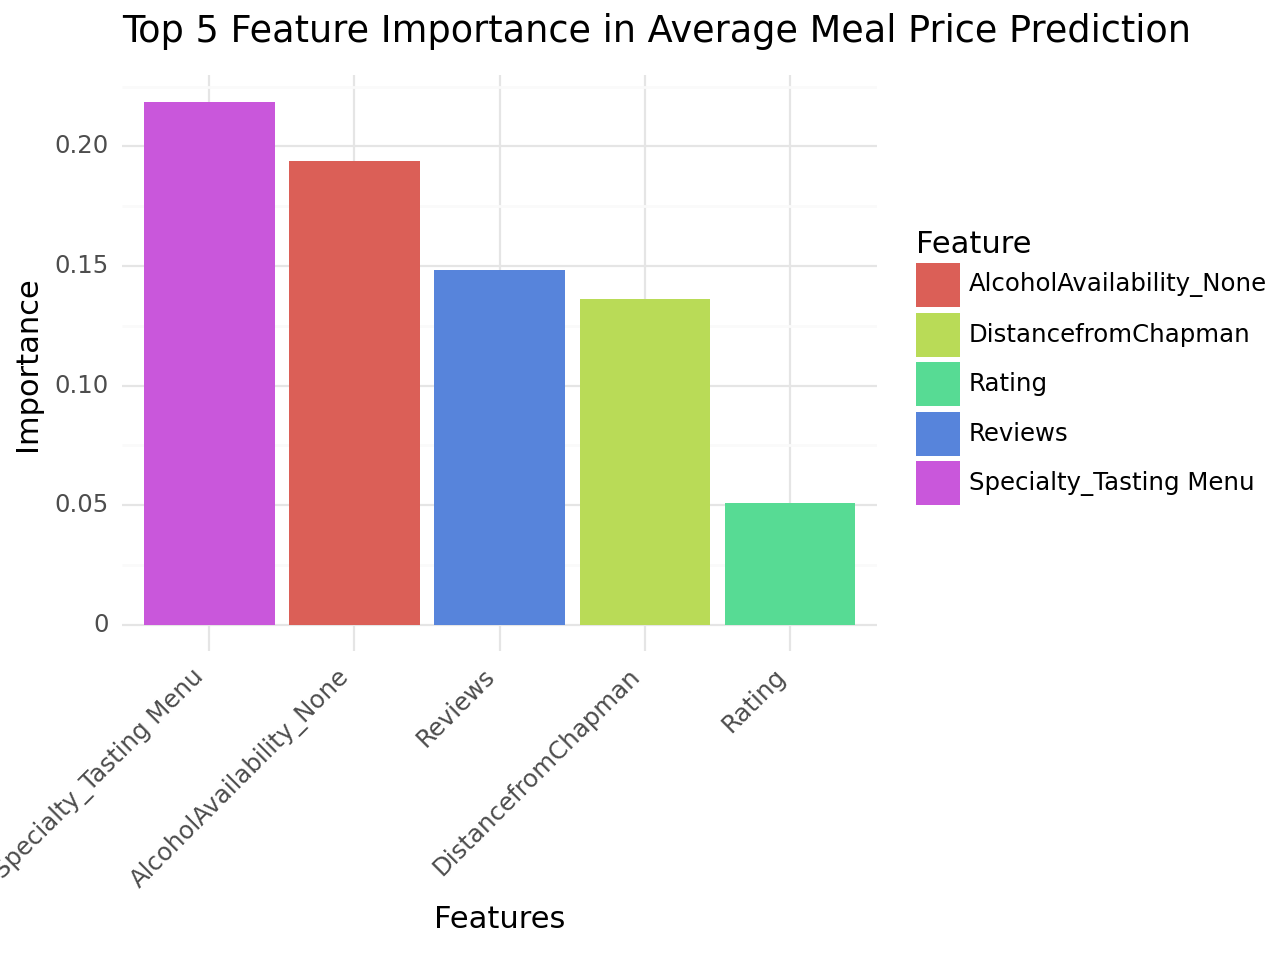

In [246]:
# code for Q6
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_point, geom_hline, labs, theme_minimal,geom_histogram, geom_boxplot,ggtitle, facet_wrap
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, theme, element_text

# Assuming you have a DataFrame 'data' with relevant columns
# Convert avgmealprice to numerical categories

data = pd.read_csv("/content/Data Science Final Dataset - Sheet1.csv")

price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
data['AverageMealPrice'] = data['AverageMealPrice'].map(price_mapping)

# Select features and target variable
features = ['RestaurantType', 'Culture', 'Specialty', 'DistancefromChapman', 'Rating',
            'Reviews', 'CompetitorDensity', 'AlcoholAvailability', 'YearsSinceOpen']

target = 'AverageMealPrice'

X = data[features]
y = data[target]

# Preprocess categorical variables
X_encoded = pd.get_dummies(X, columns=['RestaurantType', 'Culture', 'Specialty', 'AlcoholAvailability'], drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model for regression
rf_model = RandomForestRegressor(n_estimators=110, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model performance using regression metrics
y_train_pred = rf_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model performance using regression metrics on the test set
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# Print the evaluation metrics for both train and test sets
print("Training Set:")
print(f'Mean Squared Error: {mse_train}')
print(f'R-squared: {r2_train}')

print("\nTesting Set:")
print(f'Mean Squared Error: {mse_test}')
print(f'R-squared: {r2_test}')

# Extract feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
importances_df = pd.DataFrame({'Feature': X_encoded.columns, 'Importance': feature_importances})

# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importances_df)

# Sort features by importance in descending order
importances_df_sorted = importances_df.sort_values(by='Importance', ascending=False)

from plotnine import ggplot, aes, geom_point, theme_minimal, labs

# Assuming 'Reviews' is the most important feature
most_important_feature = 'Reviews'

# Create a ggplot for a detailed plot of the most important feature
p = (ggplot(data, aes(x=most_important_feature, y='DistancefromChapman', color='factor(AverageMealPrice)')) +
     geom_point(alpha=0.7) +
     labs(x=most_important_feature, y='DistancefromChapman', color='AverageMealPrice') +
     theme_minimal() +
     ggtitle(f'{most_important_feature} vs Distance from Chapman')
)

# Print the plot
print(p)

# Sort features by importance in descending order
importances_df_sorted = importances_df.sort_values(by='Importance', ascending=False)

# Select the top 5 features
top_n = 5
top_importances_df = importances_df_sorted.head(top_n)

# Create a ggplot for top feature importance with customized colors
p2 = (ggplot(top_importances_df, aes(x='reorder(Feature, -Importance)', y='Importance', fill='Feature')) +
     geom_bar(stat='identity') +
     theme_minimal() +
     labs(x='Features', y='Importance', title='Top 5 Feature Importance in Average Meal Price Prediction') +
     theme(axis_text_x=element_text(rotation=45, hjust=1))  # Rotate x-axis labels for better visibility
)

# Print the plot
print(p2)